<h1>Segmentation and Comparison of Neighborhood of Toronto & New York Using Foursquare API and Clustering</h1>

<h2>Install and import required packages</h2>

In [3]:
!pip install bs4
!pip install lxml
!conda install -c conda-forge folium=0.5.0 --yes
!conda install -c conda-forge geopy --yes 
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge folium=0.5.0 --yes

  Stored in directory: /home/dsxuser/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    altair-4.0.1               |             py_0         575 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ------------------------

In [5]:
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from urllib.request import urlopen
import random 
from geopy.geocoders import Nominatim 
from IPython.display import Image 
from IPython.core.display import HTML 
from IPython.display import display_html 

from pandas.io.json import json_normalize

import folium 
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from matplotlib import pyplot as plt



from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules


from matplotlib import pyplot as plt


from IPython.display import HTML


In [6]:
#Function to get nearby venues
CLIENT_ID = 'VW4IYSJWZOV5MEUTYKEWPEINY3TZWYE0GJHVKNUQUSJ5DVFW' # your Foursquare ID
CLIENT_SECRET = 'NORPTKWY0S0MX3LH53PPQPJ410DHEFFJMVU055BAKPE1QAH4' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=500
radius=750
def getNearbyVenues(names, latitudes, longitudes, radius=750):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)



In [127]:
# plotting configurations

%config InlineBackend.figure_format = 'retina'
plt.rc('figure', dpi=300)
plt.rc('savefig', dpi=300)
fig_size = (12,6)
big_fig_size = (18,8)
fig_fc = '#ffffff'
pc = ["#4285f4", "#db4437", "#f4b400", "#0f9d58", "#ab47bc", "#00acc1", "#ff7043", 
      "#9e9d24", "#5c6bc0", "#f06292", "#00796b", "#c2185b", "#7e57c2", "#03a9f4", 
      "#8bc34a", "#fdd835", "#fb8c00", "#8d6e63", "#9e9e9e", "#607d8b"]

def plot_conf(ax, xlbl='', ylbl='', t=''):
    """
    This function perform operations to produce better-looking 
    visualizations
    """
    # changing the background color of the plot
    ax.set_facecolor('#ffffff')
    # modifying the ticks on plot axes
    ax.tick_params(axis='both', labelcolor='#616161', color='#ffffff')
    ax.tick_params(axis='both', which='major', labelsize=9)
    # adding a grid and specifying its color
    ax.grid(True, color='#e9e9e9')
    # making the grid appear behind the graph elements
    ax.set_axisbelow(True)
    # hiding axes
    ax.spines['bottom'].set_color('#ffffff')
    ax.spines['top'].set_color('#ffffff') 
    ax.spines['right'].set_color('#ffffff')
    ax.spines['left'].set_color('#ffffff')
    # setting the title, x label, and y label of the plot
    ax.set_title(t, fontsize=14, color='#616161', loc='left', pad=24, fontweight='bold');
    ax.set_xlabel(xlbl, labelpad=16, fontsize=11, color='#616161', fontstyle='italic');
    ax.set_ylabel(ylbl, color='#616161', labelpad=16, fontsize=11, fontstyle='italic');
    
# table configuration
styles = [
    dict(selector="td, th", props=[("border", "1px solid #333"), ("padding", "2px")]),
    dict(selector="th.col_heading", props=[("background", "#eee8d5"), ("color", "#b58900"), ("padding", "5px 8px")]),
    dict(selector="th.index_name", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "5px 8px")]),
    dict(selector="th.blank", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "0")]),
    dict(selector="th.row_heading.level0", props=[("background", "rgba(133, 153, 0, 0.1)")]),
    dict(selector="th.row_heading.level1", props=[("background", "rgba(42, 161, 152, 0.1)")]),
    dict(selector="thead tr:nth-child(2) th", props=[("border-bottom", "3px solid #333333")]),
    dict(selector="td:hover", props=[("font-weight", "bold"), ("background", "#002b36"), ("color", "Gold")]),
]

disp_fmt = "<h2 style='color: #b58900'>{}<span style='color: #FF91CE; font-size: 115%'>:</span></h2>"



<h1 style="color:red;"><i>Segmentation for Toronto</i></h1>

<h2>Scrape the Canada data from the Wikipage using Beautiful Soup</h2>

In [8]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html = urlopen(url) 
soup = BeautifulSoup(html, 'html.parser')

soup


tables=soup.find_all("table",{"class":"wikitable sortable"})

import re
def process_num(num):
    return float(re.sub(r'[^\w\s.]','',num))

num1 = float(re.sub(r'[^\w\s.]','','1,156.30'))

<h2>Clean and process data</h2>

In [9]:
postcodes = []
Boroughs = []
TorNeighbourhoods = []

for table in tables:
    rows = table.find_all('tr')
        
    for row in rows:
        cells = row.find_all('td')
        
        
        if len(cells) > 1:
            postcode = cells[0]
            postcodes.append(postcode.text.strip())
            
            Borough = cells[1]
            Boroughs.append(Borough.text.strip())
            
            Neighbourhood = cells[2]
            TorNeighbourhoods.append(Neighbourhood.text.strip())
            
df1 = pd.DataFrame(postcodes, columns = ['Postcode'])
df1

df1['Borough'] = Boroughs
df1

df1['Neighbourhood'] = TorNeighbourhoods
df1


Postcode           Borough  \
0        M1A      Not assigned   
1        M2A      Not assigned   
2        M3A        North York   
3        M4A        North York   
4        M5A  Downtown Toronto   
5        M6A        North York   
6        M6A        North York   
7        M7A  Downtown Toronto   
8        M8A      Not assigned   
9        M9A         Etobicoke   
10       M1B       Scarborough   
11       M1B       Scarborough   
12       M2B      Not assigned   
13       M3B        North York   
14       M4B         East York   
15       M4B         East York   
16       M5B  Downtown Toronto   
17       M5B  Downtown Toronto   
18       M6B        North York   
19       M7B      Not assigned   
20       M8B      Not assigned   
21       M9B         Etobicoke   
22       M9B         Etobicoke   
23       M9B         Etobicoke   
24       M9B         Etobicoke   
25       M9B         Etobicoke   
26       M1C       Scarborough   
27       M1C       Scarborough   
28       M1C       Scarborough   
29       M2C      Not assigned   
..       ...               ...   
257      M9X      Not assigned   
258      M1Y      Not assigned   
259      M2Y      Not assigned   
260      M3Y      Not assigned   
261      M4Y  Downtown Toronto   
262      M5Y      Not assigned   
263      M6Y      Not assigned   
264      M7Y      East Toronto   
265      M8Y         Etobicoke   
266      M8Y         Etobicoke   
267      M8Y         Etobicoke   
268      M8Y         Etobicoke   
269      M8Y         Etobicoke   
270      M8Y         Etobicoke   
271      M8Y         Etobicoke   
272      M8Y         Etobicoke   
273      M9Y      Not assigned   
274      M1Z      Not assigned   
275      M2Z      Not assigned   
276      M3Z      Not assigned   
277      M4Z      Not assigned   
278      M5Z      Not assigned   
279      M6Z      Not assigned   
280      M7Z      Not assigned   
281      M8Z         Etobicoke   
282      M8Z         Etobicoke   
283      M8Z         Etobicoke   
284      M8Z         Etobicoke   
285      M8Z         Etobicoke   
286      M9Z      Not assigned   

                                         Neighbourhood  
0                                         Not assigned  
1                                         Not assigned  
2                                            Parkwoods  
3                                     Victoria Village  
4                                         Harbourfront  
5                                     Lawrence Heights  
6                                       Lawrence Manor  
7                                         Queen's Park  
8                                         Not assigned  
9                                     Islington Avenue  
10                                               Rouge  
11                                             Malvern  
12                                        Not assigned  
13                                     Don Mills North  
14                                    Woodbine Gardens  
15                                       Parkview Hill  
16                                             Ryerson  
17                                     Garden District  
18                                           Glencairn  
19                                        Not assigned  
20                                        Not assigned  
21                                          Cloverdale  
22                                           Islington  
23                                        Martin Grove  
24                                    Princess Gardens  
25                                     West Deane Park  
26                                      Highland Creek  
27                                          Rouge Hill  
28                                          Port Union  
29                                        Not assigned  
..                                                 ...  
257                                       Not assigned  
258           

<h4>Dropping the rows where Borough is 'Not assigned'</h4>


In [10]:
df1 = df1[df1.Borough != 'Not assigned']

<h4>Combining the neighbourhoods with same Postalcode</h4>

In [11]:
df2 = df1.groupby(['Postcode','Borough'], sort=False).agg(', '.join)
df2.reset_index(inplace=True)


<h4>Replacing the name of the neighbourhoods which are 'Not assigned' with names of Borough</h4>



In [12]:
df2['Neighbourhood'] = np.where(df2['Neighbourhood'] == 'Not assigned',df2['Borough'], df2['Neighbourhood'])

df2.reset_index(inplace=True)
TorNeighbourhoods=df2

In [13]:
# Shape of data frame
TorNeighbourhoods.shape

(103, 4)

<h4>Merging records where multiple neighborhoods share the same borough</h4>



In [14]:
TorNeighbourhoods = (TorNeighbourhoods.groupby(['Postcode', 'Borough'])['Neighbourhood']
      .apply(lambda x: "{}".format(', '.join(x))).reset_index())
TorNeighbourhoods

Postcode           Borough  \
0        M1B       Scarborough   
1        M1C       Scarborough   
2        M1E       Scarborough   
3        M1G       Scarborough   
4        M1H       Scarborough   
5        M1J       Scarborough   
6        M1K       Scarborough   
7        M1L       Scarborough   
8        M1M       Scarborough   
9        M1N       Scarborough   
10       M1P       Scarborough   
11       M1R       Scarborough   
12       M1S       Scarborough   
13       M1T       Scarborough   
14       M1V       Scarborough   
15       M1W       Scarborough   
16       M1X       Scarborough   
17       M2H        North York   
18       M2J        North York   
19       M2K        North York   
20       M2L        North York   
21       M2M        North York   
22       M2N        North York   
23       M2P        North York   
24       M2R        North York   
25       M3A        North York   
26       M3B        North York   
27       M3C        North York   
28       M3H        North York   
29       M3J        North York   
..       ...               ...   
73       M6C              York   
74       M6E              York   
75       M6G  Downtown Toronto   
76       M6H      West Toronto   
77       M6J      West Toronto   
78       M6K      West Toronto   
79       M6L        North York   
80       M6M              York   
81       M6N              York   
82       M6P      West Toronto   
83       M6R      West Toronto   
84       M6S      West Toronto   
85       M7A  Downtown Toronto   
86       M7R       Mississauga   
87       M7Y      East Toronto   
88       M8V         Etobicoke   
89       M8W         Etobicoke   
90       M8X         Etobicoke   
91       M8Y         Etobicoke   
92       M8Z         Etobicoke   
93       M9A         Etobicoke   
94       M9B         Etobicoke   
95       M9C         Etobicoke   
96       M9L        North York   
97       M9M        North York   
98       M9N              York   
99       M9P         Etobicoke   
100      M9R         Etobicoke   
101      M9V         Etobicoke   
102      M9W         Etobicoke   

                                         Neighbourhood  
0                                       Rouge, Malvern  
1               Highland Creek, Rouge Hill, Port Union  
2                    Guildwood, Morningside, West Hill  
3                                               Woburn  
4                                            Cedarbrae  
5                                  Scarborough Village  
6          East Birchmount Park, Ionview, Kennedy Park  
7                      Clairlea, Golden Mile, Oakridge  
8      Cliffcrest, Cliffside, Scarborough Village West  
9                          Birch Cliff, Cliffside West  
10   Dorset Park, Scarborough Town Centre, Wexford ...  
11                                   Maryvale, Wexford  
12                                           Agincourt  
13             Clarks Corners, Sullivan, Tam O'Shanter  
14   Agincourt North, L'Amoreaux East, Milliken, St...  
15                                     L'Amoreaux West  
16                                         Upper Rouge  
17                                   Hillcrest Village  
18                        Fairview, Henry Farm, Oriole  
19                                     Bayview Village  
20                            Silver Hills, York Mills  
21                             Newtonbrook, Willowdale  
22                                    Willowdale South  
23                                     York Mills West  
24                                     Willowdale West  
25                                           Parkwoods  
26                                     Don Mills North  
27                    Flemingdon Park, Don Mills South  
28     Bathurst Manor, Downsview North, Wilson Heights  
29                     Northwood Park, York University  
..                                                 ...  
73                                  Humewood-Cedarvale  
74            

In [15]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(TorNeighbourhoods['Borough'].unique()),
        TorNeighbourhoods.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


<h4>Fetch all data related to Toronto as the Borough</h4>

In [16]:
TorNeighbourhoods = TorNeighbourhoods[TorNeighbourhoods['Borough'].str.contains('Toronto',regex=False)]
TorNeighbourhoods.shape
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(TorNeighbourhoods['Borough'].unique()),
        TorNeighbourhoods.shape[0]
    )
)
TorNeighbourhoods.shape

The dataframe has 4 boroughs and 39 neighborhoods.


(39, 3)

In [18]:
TorNeighbourhoods.loc[TorNeighbourhoods.Neighbourhood.str.contains('Not assigned'), 'Neighbourhood'] = \
    TorNeighbourhoods.loc[TorNeighbourhoods.Neighbourhood.str.contains('Not assigned'), 'Borough']



/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


<h2>Import CSV for Geospatial data and Merge the Dataframes to get longitudes and latitudes</h2>

In [19]:
lat_lon = pd.read_csv('https://cocl.us/Geospatial_data/')
lat_lon.head()

lat_lon.rename(columns={'Postal Code':'Postcode'},inplace=True)
TorNeighbourhoods = pd.merge(TorNeighbourhoods,lat_lon,on='Postcode')
TorNeighbourhoods.head()


Postcode          Borough                   Neighbourhood   Latitude  \
0      M4E     East Toronto                     The Beaches  43.676357   
1      M4K     East Toronto    The Danforth West, Riverdale  43.679557   
2      M4L     East Toronto  The Beaches West, India Bazaar  43.668999   
3      M4M     East Toronto                 Studio District  43.659526   
4      M4N  Central Toronto                   Lawrence Park  43.728020   

   Longitude  
0 -79.293031  
1 -79.352188  
2 -79.315572  
3 -79.340923  
4 -79.388790

<h2>Data Map of all the neighbourhoods of Toronto</h2>

In [20]:
#Using geopy Library to get the Coordinates of Toronto¶
address = 'Toronto'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

map_toronto = folium.Map(location=[latitude,longitude],zoom_start=10)

for lat,lng,borough,neighbourhood in zip(TorNeighbourhoods['Latitude'],TorNeighbourhoods['Longitude'],TorNeighbourhoods['Borough'],TorNeighbourhoods['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_toronto)
map_toronto

The geograpical coordinate of Toronto are 43.653963, -79.387207.


<h2>KMeans clustering for the clustering of the Toronto neighbourhoods</h2>

In [21]:
k=5
toronto_clustering = TorNeighbourhoods.drop(['Postcode','Borough','Neighbourhood'],1)
kmeans = KMeans(n_clusters = k,random_state=0).fit(toronto_clustering)
kmeans.labels_
TorNeighbourhoods.insert(0, 'ClusterLabels', kmeans.labels_)
TorNeighbourhoods

ClusterLabels Postcode           Borough  \
0               0      M4E      East Toronto   
1               0      M4K      East Toronto   
2               0      M4L      East Toronto   
3               0      M4M      East Toronto   
4               1      M4N   Central Toronto   
5               1      M4P   Central Toronto   
6               1      M4R   Central Toronto   
7               1      M4S   Central Toronto   
8               1      M4T   Central Toronto   
9               1      M4V   Central Toronto   
10              4      M4W  Downtown Toronto   
11              4      M4X  Downtown Toronto   
12              4      M4Y  Downtown Toronto   
13              4      M5A  Downtown Toronto   
14              4      M5B  Downtown Toronto   
15              4      M5C  Downtown Toronto   
16              4      M5E  Downtown Toronto   
17              4      M5G  Downtown Toronto   
18              4      M5H  Downtown Toronto   
19              4      M5J  Downtown Toronto   
20              4      M5K  Downtown Toronto   
21              4      M5L  Downtown Toronto   
22              1      M5N   Central Toronto   
23              1      M5P   Central Toronto   
24              3      M5R   Central Toronto   
25              3      M5S  Downtown Toronto   
26              3      M5T  Downtown Toronto   
27              4      M5V  Downtown Toronto   
28              4      M5W  Downtown Toronto   
29              4      M5X  Downtown Toronto   
30              3      M6G  Downtown Toronto   
31              2      M6H      West Toronto   
32              3      M6J      West Toronto   
33              3      M6K      West Toronto   
34              2      M6P      West Toronto   
35              2      M6R      West Toronto   
36              2      M6S      West Toronto   
37              4      M7A  Downtown Toronto   
38              0      M7Y      East Toronto   

                                        Neighbourhood   Latitude  Longitude  
0                                         The Beaches  43.676357 -79.293031  
1                        The Danforth West, Riverdale  43.679557 -79.352188  
2                      The Beaches West, India Bazaar  43.668999 -79.315572  
3                                     Studio District  43.659526 -79.340923  
4                                       Lawrence Park  43.728020 -79.388790  
5                                    Davisville North  43.712751 -79.390197  
6                                  North Toronto West  43.715383 -79.405678  
7                                          Davisville  43.704324 -79.388790  
8                         Moore Park, Summerhill East  43.689574 -79.383160  
9   Deer Park, Forest Hill SE, Rathnelly, South Hi...  43.686412 -79.400049  
10                                           Rosedale  43.679563 -79.377529  
11                        Cabbagetown, St. James Town  43.667967 -79.367675  
12                               Church and Wellesley  43.665860 -79.383160  
13                                       Harbourfront  43.654260 -79.360636  
14                           Ryerson, Garden District  43.657162 -79.378937  
15                                     St. James Town  43.651494 -79.375418  
16                                        Berczy Park  43.644771 -79.373306  
17                                 Central Bay Street  43.657952 -79.387383  
18                           Adelaide, King, Richmond  43.650571 -79.384568  
19  Harbourfront East, Toronto Islands, Union Station  43.640816 -79.381752  
20           Design Exchange, Toronto Dominion Centre  43.647177 -79.381576  
21                     Commerce Court, Victoria Hotel  43.648198 -79.379817  
22                                           Roselawn  43.711695 -79.416936  
23                Forest Hill North, Forest Hill West  43.696948 -79.411307  
24                The Annex, North Midtown, Yorkville  43.672710 -79.405678  
25                     Harbord, University of Toronto  

In [22]:
# create map of Toronto using latitude and longitude values
map_clusters = folium.Map(location=[43.651070,-79.347015],zoom_start=10)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighbourhood, cluster in zip(TorNeighbourhoods['Latitude'], TorNeighbourhoods['Longitude'], TorNeighbourhoods['Neighbourhood'], 
                                            TorNeighbourhoods['ClusterLabels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<h2>Retrieving Venue Data For Toronto</h2>


In [23]:
#Function to get nearby venues
CLIENT_ID = 'VW4IYSJWZOV5MEUTYKEWPEINY3TZWYE0GJHVKNUQUSJ5DVFW' # your Foursquare ID
CLIENT_SECRET = 'NORPTKWY0S0MX3LH53PPQPJ410DHEFFJMVU055BAKPE1QAH4' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=500
radius=750
def getNearbyVenues(names, latitudes, longitudes, radius=750):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


tor_venues = getNearbyVenues(names=TorNeighbourhoods['Neighbourhood'],
                             latitudes=TorNeighbourhoods['Latitude'],
                             longitudes=TorNeighbourhoods['Longitude']
                            )

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The Junction Sout

In [26]:
# Removing records where venue is "building" or "office"
tor_venues = tor_venues[~tor_venues['Venue Category'].isin(['Building', 'Office', 'Bus Line', 'Bus Station', 'Bus Stop', 'Road'])]
print(tor_venues.shape)
tor_venues.head()

(2689, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  The Beaches              43.676357              -79.293031   
1  The Beaches              43.676357              -79.293031   
2  The Beaches              43.676357              -79.293031   
3  The Beaches              43.676357              -79.293031   
4  The Beaches              43.676357              -79.293031   

               Venue  Venue Latitude  Venue Longitude  \
0  Glen Manor Ravine       43.676821       -79.293942   
1    Tori's Bakeshop       43.672114       -79.290331   
2     The Beech Tree       43.680493       -79.288846   
3  Beaches Bake Shop       43.680363       -79.289692   
4    The Fox Theatre       43.672801       -79.287272   

                  Venue Category  
0                          Trail  
1  Vegetarian / Vegan Restaurant  
2                      Gastropub  
3                         Bakery  
4            Indie Movie Theater

<h2>Let's check how many venues were returned for each neighborhood</h2>


In [25]:
tor_venues.groupby('Neighborhood').size()


Neighborhood
Adelaide, King, Richmond                                                                                       99
Berczy Park                                                                                                   100
Brockton, Exhibition Place, Parkdale Village                                                                   84
Business Reply Mail Processing Centre 969 Eastern                                                              52
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara     26
Cabbagetown, St. James Town                                                                                    67
Central Bay Street                                                                                             98
Chinatown, Grange Park, Kensington Market                                                                     100
Christie                                                                   

In [27]:
TorNeighbourhoods.shape[0], tor_venues['Neighborhood'].unique().shape[0]


(39, 39)


<h4>c</h4>

In [28]:
tor_excluded_neighborhoods = set(TorNeighbourhoods['Neighbourhood']).difference(set(tor_venues['Neighborhood']))
tor_excluded_neighborhoods

set()

<h4>Let's find out how many unique categories can be curated from all the returned venues</h4>


In [64]:
print('There are {} uniques categories.'.format(len(tor_venues['Venue Category'].unique())))


There are 281 uniques categories.


<h3>Performing one-hot on the venue category variable</h3>


In [29]:
# one hot encoding
tor_onehot = pd.get_dummies(tor_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
# we used Neighborhood_" instead of just "Neighborhood" because
# there is a venue category called "Neighborhood"
tor_onehot['Neighborhood_'] = tor_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [tor_onehot.columns[-1]] + list(tor_onehot.columns[:-1])
tor_onehot = tor_onehot[fixed_columns]

tor_onehot.head()

Neighborhood_  Accessories Store  Afghan Restaurant  Airport  \
0   The Beaches                  0                  0        0   
1   The Beaches                  0                  0        0   
2   The Beaches                  0                  0        0   
3   The Beaches                  0                  0        0   
4   The Beaches                  0                  0        0   

   Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0                   0             0               0                0   
1                   0             0               0                0   
2                   0             0               0                0   
3                   0             0               0                0   
4                   0             0               0                0   

   Airport Terminal  American Restaurant  ...  University  \
0                 0                    0  ...           0   
1                 0                    0  ...           0   
2                 0                    0  ...           0   
3                 0                    0  ...           0   
4                 0                    0  ...           0   

   Vegetarian / Vegan Restaurant  Video Game Store  Video Store  \
0                              0                 0            0   
1                              1                 0            0   
2                              0                 0            0   
3                              0                 0            0   
4                              0                 0            0   

   Vietnamese Restaurant  Wine Bar  Wine Shop  Wings Joint  Women's Store  \
0                      0         0          0            0              0   
1                      0         0          0            0              0   
2                      0         0          0            0              0   
3                      0         0          0            0              0   
4                      0         0          0            0              0   

   Yoga Studio  
0            0  
1            0  
2            0  
3            0  
4            0  

[5 rows x 283 columns]

<h3>Grouping rows by neighborhood and taking the mean of the frequency of occurrence of each category for each neighborhood</h3>


In [30]:
tor_grouped = tor_onehot.groupby('Neighborhood_').mean().reset_index()
tor_grouped.head()

Neighborhood_  Accessories Store  \
0                           Adelaide, King, Richmond           0.000000   
1                                        Berczy Park           0.000000   
2       Brockton, Exhibition Place, Parkdale Village           0.011905   
3  Business Reply Mail Processing Centre 969 Eastern           0.000000   
4  CN Tower, Bathurst Quay, Island airport, Harbo...           0.000000   

   Afghan Restaurant   Airport  Airport Food Court  Airport Gate  \
0                0.0  0.000000            0.000000      0.000000   
1                0.0  0.000000            0.000000      0.000000   
2                0.0  0.000000            0.000000      0.000000   
3                0.0  0.000000            0.000000      0.000000   
4                0.0  0.038462            0.038462      0.038462   

   Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0        0.000000         0.000000          0.000000             0.020202   
1        0.000000         0.000000          0.000000             0.000000   
2        0.000000         0.000000          0.000000             0.011905   
3        0.000000         0.000000          0.000000             0.000000   
4        0.076923         0.076923          0.076923             0.000000   

   ...  University  Vegetarian / Vegan Restaurant  Video Game Store  \
0  ...         0.0                       0.020202               0.0   
1  ...         0.0                       0.010000               0.0   
2  ...         0.0                       0.011905               0.0   
3  ...         0.0                       0.000000               0.0   
4  ...         0.0                       0.000000               0.0   

   Video Store  Vietnamese Restaurant  Wine Bar  Wine Shop  Wings Joint  \
0          0.0                    0.0  0.010101   0.000000          0.0   
1          0.0                    0.0  0.000000   0.000000          0.0   
2          0.0                    0.0  0.000000   0.000000          0.0   
3          0.0                    0.0  0.000000   0.019231          0.0   
4          0.0                    0.0  0.000000   0.000000          0.0   

   Women's Store  Yoga Studio  
0            0.0     0.000000  
1            0.0     0.000000  
2            0.0     0.000000  
3            0.0     0.019231  
4            0.0     0.000000  

[5 rows x 283 columns]

<h3>The most common categories for each neighborhood</h3>


In [31]:
def return_most_common_venues(row, num_top_cat):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_cat]


num_top_cat = 7
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood_']
for ind in np.arange(num_top_cat):
    try:
        columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Category'.format(ind+1))

# create a new dataframe
tor_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
tor_neighborhoods_categories_sorted['Neighborhood_'] = tor_grouped['Neighborhood_']

for ind in np.arange(tor_grouped.shape[0]):
    tor_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        tor_grouped.iloc[ind, :], num_top_cat)

tor_neighborhoods_categories_sorted.head()

Neighborhood_ 1st Most Common Category  \
0                           Adelaide, King, Richmond              Coffee Shop   
1                                        Berczy Park              Coffee Shop   
2       Brockton, Exhibition Place, Parkdale Village              Coffee Shop   
3  Business Reply Mail Processing Centre 969 Eastern     Fast Food Restaurant   
4  CN Tower, Bathurst Quay, Island airport, Harbo...          Harbor / Marina   

  2nd Most Common Category 3rd Most Common Category 4th Most Common Category  \
0                     Café               Restaurant         Sushi Restaurant   
1               Restaurant                    Hotel                     Café   
2                     Café                Gift Shop                   Bakery   
3                      Bar       Italian Restaurant                     Park   
4         Sculpture Garden              Coffee Shop           Airport Lounge   

  5th Most Common Category 6th Most Common Category 7th Most Common Category  
0                      Bar               Steakhouse                  Theater  
1                 Beer Bar      Japanese Restaurant           Farmers Market  
2                      Bar               Restaurant      Japanese Restaurant  
3            Burrito Place                   Bakery       Light Rail Station  
4          Airport Service         Airport Terminal      Rental Car Location

<h2>Clustering</h2>

<h4>Now we apply K-means clustering on the dataframe stored in toronto_grouped variable which includes the relative 
frequency of each venue-category for each neighborhood.</h4>


In [32]:
# set number of clusters
kclusters = 5

tor_grouped_clustering = tor_grouped.drop('Neighborhood_', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 0, 2], dtype=int32)

In [33]:
tor_neighborhoods_categories_sorted
# add clustering label

tor_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

tor_merged = TorNeighbourhoods.rename(columns={'Neighbourhood': 'Neighborhood_'}).copy()
#tor_merged = tor_merged[~tor_merged['Neighborhood_'].isin(tor_excluded_neighborhoods)]
tor_merged
tor_neighborhoods_categories_sorted
## merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
tor_merged = tor_merged.join(tor_neighborhoods_categories_sorted.set_index('Neighborhood_'), on='Neighborhood_')

tor_merged.head() # check the last columns!


ClusterLabels Postcode          Borough                   Neighborhood_  \
0              0      M4E     East Toronto                     The Beaches   
1              0      M4K     East Toronto    The Danforth West, Riverdale   
2              0      M4L     East Toronto  The Beaches West, India Bazaar   
3              0      M4M     East Toronto                 Studio District   
4              1      M4N  Central Toronto                   Lawrence Park   

    Latitude  Longitude  Cluster Labels 1st Most Common Category  \
0  43.676357 -79.293031               2                      Pub   
1  43.679557 -79.352188               2         Greek Restaurant   
2  43.668999 -79.315572               0        Indian Restaurant   
3  43.659526 -79.340923               2                     Café   
4  43.728020 -79.388790               4              Swim School   

  2nd Most Common Category 3rd Most Common Category 4th Most Common Category  \
0        Health Food Store           Sandwich Place           Breakfast Spot   
1              Coffee Shop                      Pub                     Café   
2            Grocery Store           Sandwich Place                      Gym   
3                      Bar              Coffee Shop                   Bakery   
4                     Park              Coffee Shop         Business Service   

  5th Most Common Category     6th Most Common Category  \
0      Japanese Restaurant                          Bar   
1           Ice Cream Shop           Italian Restaurant   
2       Italian Restaurant                  Coffee Shop   
3                    Diner          American Restaurant   
4              Yoga Studio  Eastern European Restaurant   

  7th Most Common Category  
0            Grocery Store  
1     Fast Food Restaurant  
2           Discount Store  
3       Italian Restaurant  
4         Doner Restaurant

<h3>Creating a map that shows the neighborhoods and their clusters</h3>
<h4>We will create a map that shows a marker for each neighborhood; the color of the marker represents the cluster 
of the neighborhood.</h4>


In [34]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9,
                          min_zoom=8, max_zoom=10)

# set color scheme for the clusters
rainbow = pc[:5]

# add markers to the map
for lat, lon, poi, cluster in zip(tor_merged['Latitude'], tor_merged['Longitude'], 
                                  tor_merged['Neighborhood_'], tor_merged['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        weight=1,
        popup=label,
        color='#333333',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

<h3>Examining clusters</h3>
<h4>Let's see the neighborhoods in each of the five clusters:</h4>


In [35]:
tor_merged.loc[tor_merged['Cluster Labels'] == 0, 
               tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

Postcode  Longitude  Cluster Labels 1st Most Common Category  \
2       M4L -79.315572               0        Indian Restaurant   
8       M4T -79.383160               0            Grocery Store   
30      M6G -79.422564               0            Grocery Store   

   2nd Most Common Category 3rd Most Common Category 4th Most Common Category  \
2             Grocery Store           Sandwich Place                      Gym   
8                      Park           Sandwich Place                     Café   
30                     Park                     Café        Indian Restaurant   

   5th Most Common Category 6th Most Common Category 7th Most Common Category  
2        Italian Restaurant              Coffee Shop           Discount Store  
8               Candy Store     Gym / Fitness Center                      Gym  
30                    Diner       Italian Restaurant              Coffee Shop

In [112]:
tor_merged.loc[tor_merged['Cluster Labels'] == 1, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]



Postcode  Longitude  Cluster Labels 1st Most Common Category  \
23      M5P -79.411307               1                     Park   

   2nd Most Common Category 3rd Most Common Category 4th Most Common Category  \
23            Jewelry Store         Sushi Restaurant                    Trail   

   5th Most Common Category 6th Most Common Category 7th Most Common Category  
23              Yoga Studio                 Dive Bar                  Dog Run

In [113]:
tor_merged.loc[tor_merged['Cluster Labels'] == 2, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]



Postcode  Longitude  Cluster Labels 1st Most Common Category  \
22      M5N -79.416936               2               Playground   

   2nd Most Common Category 3rd Most Common Category 4th Most Common Category  \
22           Ice Cream Shop                   Garden           Farmers Market   

   5th Most Common Category 6th Most Common Category 7th Most Common Category  
22     Fast Food Restaurant                     Farm       Falafel Restaurant

In [114]:
tor_merged.loc[tor_merged['Cluster Labels'] == 3, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]



Postcode  Longitude  Cluster Labels 1st Most Common Category  \
8       M4T -79.383160               3                     Park   
10      M4W -79.377529               3                     Park   

   2nd Most Common Category 3rd Most Common Category 4th Most Common Category  \
8      Gym / Fitness Center            Grocery Store               Playground   
10                    Trail              Candy Store               Playground   

   5th Most Common Category 6th Most Common Category 7th Most Common Category  
8                      Café              Candy Store           Sandwich Place  
10     Gym / Fitness Center      Distribution Center                 Dive Bar

In [115]:
tor_merged.loc[tor_merged['Cluster Labels'] == 4, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]



Postcode  Longitude  Cluster Labels 1st Most Common Category  \
4      M4N  -79.38879               4                     Park   

  2nd Most Common Category 3rd Most Common Category 4th Most Common Category  \
4              Swim School              Coffee Shop         Business Service   

  5th Most Common Category 6th Most Common Category 7th Most Common Category  
4              Yoga Studio                 Dive Bar                  Dog Run


<h2 style="color:red;"><i>Segmentation for Newyork</i></h2>

In [66]:
import json
!wget -q -O 'nyu_2451_34572-geojson.json' https://cocl.us/new_york_dataset
with open('nyu_2451_34572-geojson.json') as json_data:
    newyork_nigh = json.load(json_data)
ny_neigh = newyork_nigh['features']
# define the dataframe columns


In [67]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
NYneighborhoods = pd.DataFrame(columns=column_names)
for data in ny_neigh:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    NYneighborhoods = NYneighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
NYneighborhoods.shape

(306, 4)

In [38]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(NYneighborhoods['Borough'].unique()),
        NYneighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


<h3>However, in this dataframe, there are neighborhoods that share the same name but are located in different boroughs 
as shown below:</h3>


In [39]:
nnvc = NYneighborhoods['Neighborhood'].value_counts()
nnvc[nnvc > 1]

Murray Hill    2
Sunnyside      2
Bay Terrace    2
Chelsea        2
Name: Neighborhood, dtype: int64

In [76]:
NYneighborhoods[NYneighborhoods['Neighborhood'] == 'Bay Terrace']

Empty DataFrame
Columns: [Borough, Neighborhood, Latitude, Longitude]
Index: []

<h4>To deal with this case, we will include the borough name in the name of these neighborhoods. 
For example, "Bay Terrace" neighborhood which is located in "Staten Island" 
borough will be named "Bay Terrace, Staten Island" and the one in "Queens" will be named "Bay Terrace, Queens":</h4>

In [68]:
for i in range(NYneighborhoods.shape[0]):
    nyn_ = NYneighborhoods.loc[i, 'Neighborhood']
    if NYneighborhoods[NYneighborhoods['Neighborhood'] == nyn_].shape[0] > 1:
        ind_ = NYneighborhoods[NYneighborhoods['Neighborhood'] == nyn_].index.tolist()
        for j in ind_:
            nyb__ = NYneighborhoods.loc[j, 'Borough']
            NYneighborhoods.loc[j, 'Neighborhood'] = nyn_ + ', ' + nyb__

In [78]:
NYneighborhoods[NYneighborhoods['Neighborhood'].str.startswith('Bay Terrace')]

Borough                Neighborhood   Latitude  Longitude
175         Queens         Bay Terrace, Queens  40.782843 -73.776802
235  Staten Island  Bay Terrace, Staten Island  40.553988 -74.139166

In [44]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(NYneighborhoods['Latitude'], NYneighborhoods['Longitude'], NYneighborhoods['Borough'], NYneighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


<h2>KMeans clustering for the clsutering of the neighbourhoods in New York</h2>




In [45]:
k=5
newyork_clustering = NYneighborhoods.drop(['Borough','Neighborhood'],1)
kmeans = KMeans(n_clusters = k,random_state=0).fit(newyork_clustering)
kmeans.labels_
NYneighborhoods.insert(0, 'Cluster Labels', kmeans.labels_)
NYneighborhoods


Cluster Labels        Borough         Neighborhood   Latitude  Longitude
0                 4          Bronx            Wakefield  40.894705 -73.847201
1                 4          Bronx           Co-op City  40.874294 -73.829939
2                 4          Bronx          Eastchester  40.887556 -73.827806
3                 4          Bronx            Fieldston  40.895437 -73.905643
4                 4          Bronx            Riverdale  40.890834 -73.912585
5                 4          Bronx          Kingsbridge  40.881687 -73.902818
6                 4      Manhattan          Marble Hill  40.876551 -73.910660
7                 4          Bronx             Woodlawn  40.898273 -73.867315
8                 4          Bronx              Norwood  40.877224 -73.879391
9                 4          Bronx       Williamsbridge  40.881039 -73.857446
10                4          Bronx           Baychester  40.866858 -73.835798
11                4          Bronx       Pelham Parkway  40.857413 -73.854756
12                4          Bronx          City Island  40.847247 -73.786488
13                4          Bronx         Bedford Park  40.870185 -73.885512
14                4          Bronx   University Heights  40.855727 -73.910416
15                4          Bronx       Morris Heights  40.847898 -73.919672
16                4          Bronx              Fordham  40.860997 -73.896427
17                4          Bronx         East Tremont  40.842696 -73.887356
18                4          Bronx           West Farms  40.839475 -73.877745
19                4          Bronx         High  Bridge  40.836623 -73.926102
20                4          Bronx              Melrose  40.819754 -73.909422
21                4          Bronx           Mott Haven  40.806239 -73.916100
22                4          Bronx          Port Morris  40.801664 -73.913221
23                4          Bronx             Longwood  40.815099 -73.895788
24                4          Bronx          Hunts Point  40.809730 -73.883315
25                4          Bronx           Morrisania  40.823592 -73.901506
26                4          Bronx            Soundview  40.821012 -73.865746
27                4          Bronx         Clason Point  40.806551 -73.854144
28                4          Bronx          Throgs Neck  40.815109 -73.816350
29                4          Bronx         Country Club  40.844246 -73.824099
..              ...            ...                  ...        ...        ...
276               2      Manhattan             Flatiron  40.739673 -73.990947
277               2         Queens    Sunnyside Gardens  40.745652 -73.918193
278               2         Queens           Blissville  40.737251 -73.932442
279               2       Brooklyn         Fulton Ferry  40.703281 -73.995508
280               2       Brooklyn         Vinegar Hill  40.703321 -73.981116
281               3       Brooklyn           Weeksville  40.675040 -73.930531
282               3       Brooklyn    Broadway Junction  40.677861 -73.903317
283               2       Brooklyn                Dumbo  40.703176 -73.988753
284               1  Staten Island        Manor Heights  40.601810 -74.120594
285               1  Staten Island          Willowbrook  40.603707 -74.132084
286               1  Staten Island         Sandy Ground  40.541140 -74.217766
287               1  Staten Island          Egbertville  40.579119 -74.127272
288               3         Queens              Roxbury  40.567376 -73.892138
289               3       Brooklyn            Homecrest  40.598525 -73.959185
290               0         Queens       Middle Village  40.716415 -73.881143
291               1  Staten Island         Prince's Bay  40.526264 -74.201526
292               1  Staten Island      Lighthouse Hill  40.576506 -74.137927
293               1  Staten Island      Richmond Valley  40.519541 -74.229571
294               4         Queens                Malba  40.790602 -73.826678
295               3       B

In [46]:
# create map of New York using latitude and longitude values
map_clusters = folium.Map(location=[40.7127281,-74.0060152],zoom_start=10)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighborhood, cluster in zip(NYneighborhoods['Latitude'], NYneighborhoods['Longitude'], NYneighborhoods['Neighborhood'],
                                           NYneighborhoods['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<h1>2. Exploring Neighbourhoods </h1>

<h2>Exploring neighourhoods of New York</h2>

In [47]:
# I only want to look at neighborhoods in the Bronx and Brooklyn. 
# Drop rows with Manhattan, Queens, and Staten Island.
NYneighborhoods.drop(NYneighborhoods.index[NYneighborhoods['Borough'] == 'Manhattan'], inplace = True)
NYneighborhoods.drop(NYneighborhoods.index[NYneighborhoods['Borough'] == 'Queens'], inplace = True)
NYneighborhoods.drop(NYneighborhoods.index[NYneighborhoods['Borough'] == 'Staten Island'], inplace = True)
NYneighborhoods

Cluster Labels   Borough         Neighborhood   Latitude  Longitude
0                 4     Bronx            Wakefield  40.894705 -73.847201
1                 4     Bronx           Co-op City  40.874294 -73.829939
2                 4     Bronx          Eastchester  40.887556 -73.827806
3                 4     Bronx            Fieldston  40.895437 -73.905643
4                 4     Bronx            Riverdale  40.890834 -73.912585
5                 4     Bronx          Kingsbridge  40.881687 -73.902818
7                 4     Bronx             Woodlawn  40.898273 -73.867315
8                 4     Bronx              Norwood  40.877224 -73.879391
9                 4     Bronx       Williamsbridge  40.881039 -73.857446
10                4     Bronx           Baychester  40.866858 -73.835798
11                4     Bronx       Pelham Parkway  40.857413 -73.854756
12                4     Bronx          City Island  40.847247 -73.786488
13                4     Bronx         Bedford Park  40.870185 -73.885512
14                4     Bronx   University Heights  40.855727 -73.910416
15                4     Bronx       Morris Heights  40.847898 -73.919672
16                4     Bronx              Fordham  40.860997 -73.896427
17                4     Bronx         East Tremont  40.842696 -73.887356
18                4     Bronx           West Farms  40.839475 -73.877745
19                4     Bronx         High  Bridge  40.836623 -73.926102
20                4     Bronx              Melrose  40.819754 -73.909422
21                4     Bronx           Mott Haven  40.806239 -73.916100
22                4     Bronx          Port Morris  40.801664 -73.913221
23                4     Bronx             Longwood  40.815099 -73.895788
24                4     Bronx          Hunts Point  40.809730 -73.883315
25                4     Bronx           Morrisania  40.823592 -73.901506
26                4     Bronx            Soundview  40.821012 -73.865746
27                4     Bronx         Clason Point  40.806551 -73.854144
28                4     Bronx          Throgs Neck  40.815109 -73.816350
29                4     Bronx         Country Club  40.844246 -73.824099
30                4     Bronx          Parkchester  40.837938 -73.856003
..              ...       ...                  ...        ...        ...
93                3  Brooklyn  Prospect Park South  40.647009 -73.962613
94                3  Brooklyn           Georgetown  40.623845 -73.916075
95                2  Brooklyn    East Williamsburg  40.708492 -73.938858
96                2  Brooklyn           North Side  40.714823 -73.958809
97                2  Brooklyn           South Side  40.710861 -73.958001
98                3  Brooklyn        Ocean Parkway  40.613060 -73.968367
99                3  Brooklyn        Fort Hamilton  40.614768 -74.031979
221               3  Brooklyn          Ditmas Park  40.643675 -73.961013
222               3  Brooklyn              Wingate  40.660947 -73.937187
223               3  Brooklyn                Rugby  40.655572 -73.926882
259               3  Brooklyn       Remsen Village  40.652117 -73.916653
260               3  Brooklyn             New Lots  40.662744 -73.885118
261               3  Brooklyn      Paerdegat Basin  40.631318 -73.902335
262               3  Brooklyn           Mill Basin  40.615974 -73.915154
267               4     Bronx    Claremont Village  40.831428 -73.901199
268               4     Bronx    Concourse Village  40.824780 -73.915847
269               4     Bronx           Mount Eden  40.843826 -73.916556
270               4     Bronx           Mount Hope  40.848842 -73.908299
279               2  Brooklyn         Fulton Ferry  40.703281 -73.995508
280               2  Brooklyn         Vinegar Hill  40.703321 -73.981116
281               3  Brooklyn           Weeksville  40.675040 -73.930531
282               3  Brooklyn    Broadway Junction  40.677861 -73.903317
283               2  Brooklyn                Dumbo  40.703176 -

In [69]:

# Check to make sure  Bronx and Brooklyn are left in the dataframe.
NYneighborhoods.Borough.unique()

array(['Bronx', 'Manhattan', 'Brooklyn', 'Queens', 'Staten Island'],
      dtype=object)

In [70]:
NYneighborhoods.reset_index(drop=True)

Borough         Neighborhood   Latitude  Longitude
0            Bronx            Wakefield  40.894705 -73.847201
1            Bronx           Co-op City  40.874294 -73.829939
2            Bronx          Eastchester  40.887556 -73.827806
3            Bronx            Fieldston  40.895437 -73.905643
4            Bronx            Riverdale  40.890834 -73.912585
5            Bronx          Kingsbridge  40.881687 -73.902818
6        Manhattan          Marble Hill  40.876551 -73.910660
7            Bronx             Woodlawn  40.898273 -73.867315
8            Bronx              Norwood  40.877224 -73.879391
9            Bronx       Williamsbridge  40.881039 -73.857446
10           Bronx           Baychester  40.866858 -73.835798
11           Bronx       Pelham Parkway  40.857413 -73.854756
12           Bronx          City Island  40.847247 -73.786488
13           Bronx         Bedford Park  40.870185 -73.885512
14           Bronx   University Heights  40.855727 -73.910416
15           Bronx       Morris Heights  40.847898 -73.919672
16           Bronx              Fordham  40.860997 -73.896427
17           Bronx         East Tremont  40.842696 -73.887356
18           Bronx           West Farms  40.839475 -73.877745
19           Bronx         High  Bridge  40.836623 -73.926102
20           Bronx              Melrose  40.819754 -73.909422
21           Bronx           Mott Haven  40.806239 -73.916100
22           Bronx          Port Morris  40.801664 -73.913221
23           Bronx             Longwood  40.815099 -73.895788
24           Bronx          Hunts Point  40.809730 -73.883315
25           Bronx           Morrisania  40.823592 -73.901506
26           Bronx            Soundview  40.821012 -73.865746
27           Bronx         Clason Point  40.806551 -73.854144
28           Bronx          Throgs Neck  40.815109 -73.816350
29           Bronx         Country Club  40.844246 -73.824099
..             ...                  ...        ...        ...
276      Manhattan             Flatiron  40.739673 -73.990947
277         Queens    Sunnyside Gardens  40.745652 -73.918193
278         Queens           Blissville  40.737251 -73.932442
279       Brooklyn         Fulton Ferry  40.703281 -73.995508
280       Brooklyn         Vinegar Hill  40.703321 -73.981116
281       Brooklyn           Weeksville  40.675040 -73.930531
282       Brooklyn    Broadway Junction  40.677861 -73.903317
283       Brooklyn                Dumbo  40.703176 -73.988753
284  Staten Island        Manor Heights  40.601810 -74.120594
285  Staten Island          Willowbrook  40.603707 -74.132084
286  Staten Island         Sandy Ground  40.541140 -74.217766
287  Staten Island          Egbertville  40.579119 -74.127272
288         Queens              Roxbury  40.567376 -73.892138
289       Brooklyn            Homecrest  40.598525 -73.959185
290         Queens       Middle Village  40.716415 -73.881143
291  Staten Island         Prince's Bay  40.526264 -74.201526
292  Staten Island      Lighthouse Hill  40.576506 -74.137927
293  Staten Island      Richmond Valley  40.519541 -74.229571
294         Queens                Malba  40.790602 -73.826678
295       Brooklyn        Highland Park  40.681999 -73.890346
296       Brooklyn              Madison  40.609378 -73.948415
297          Bronx            Bronxdale  40.852723 -73.861726
298          Bronx             Allerton  40.865788 -73.859319
299          Bronx  Kingsbridge Heights  40.870392 -73.901523
300       Brooklyn              Erasmus  40.646926 -73.948177
301      Manhattan         Hudson Yards  40.756658 -74.000111
302         Queens              Hammels  40.587338 -73.805530
303         Queens            Bayswater  40.611322 -73.765968
304         Queens         Queensbridge  40.756091 -73.945631
305  Staten Island            Fox Hills  40.617311 -74.081740

[306 rows x 4 columns]

In [130]:
# Check to see how many neighborhoods there are.
print('The dataframe has {} boroughs and {} neighborhoods.'.format(len(NYneighborhoods['Borough'].unique()),NYneighborhoods.shape[0])

SyntaxError: unexpected EOF while parsing (<ipython-input-130-602bc4877299>, line 2)

In [131]:
#Function to get nearby venues
CLIENT_ID = 'VW4IYSJWZOV5MEUTYKEWPEINY3TZWYE0GJHVKNUQUSJ5DVFW' # your Foursquare ID
CLIENT_SECRET = 'NORPTKWY0S0MX3LH53PPQPJ410DHEFFJMVU055BAKPE1QAH4' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=500
radius=750

In [48]:
#Function to get nearby venues
CLIENT_ID = 'VW4IYSJWZOV5MEUTYKEWPEINY3TZWYE0GJHVKNUQUSJ5DVFW' # your Foursquare ID
CLIENT_SECRET = 'NORPTKWY0S0MX3LH53PPQPJ410DHEFFJMVU055BAKPE1QAH4' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=500
radius=750
def getNearbyVenues(names, latitudes, longitudes, radius=750):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [165]:
# Run the above function on each neighborhood and create a new dataframe.
NYneighborhoods_venues = getNearbyVenues(names=NYneighborhoods['Neighborhood'],
                                 latitudes=NYneighborhoods['Latitude'],
                                 longitudes=NYneighborhoods['Longitude'])
print(NYneighborhoods_venues.shape)

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [36]:
print(NYneighborhoods_venues.shape)

(15443, 7)


In [79]:
# Removing records where venue is "building" or "office"
NYneighborhoods_venues = NYneighborhoods_venues[~NYneighborhoods_venues['Venue Category'].isin(['Building', 'Office', 'Bus Line', 'Bus Station', 'Bus Stop', 'Road'])]
print(NYneighborhoods_venues.shape)
NYneighborhoods_venues.head()

(15476, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
2    Wakefield              40.894705              -73.847201   
3    Wakefield              40.894705              -73.847201   
4    Wakefield              40.894705              -73.847201   

                         Venue  Venue Latitude  Venue Longitude  \
0             Lollipops Gelato       40.894123       -73.845892   
1                     Rite Aid       40.896649       -73.844846   
2             Carvel Ice Cream       40.890487       -73.848568   
3                    Walgreens       40.896687       -73.844850   
4  Jackie's West Indian Bakery       40.889283       -73.843310   

         Venue Category  
0          Dessert Shop  
1              Pharmacy  
2        Ice Cream Shop  
3              Pharmacy  
4  Caribbean Restaurant

In [35]:
NYneighborhoods_venues.shape


(15443, 7)

In [81]:
nyc_excluded_neighborhoods = set(NYneighborhoods['Neighborhood']).difference(NYneighborhoods_venues['Neighborhood'])
nyc_excluded_neighborhoods

set()

In [82]:
NYneighborhoods.shape[0], NYneighborhoods_venues['Neighborhood'].unique().shape[0]

(306, 306)

In [83]:
NYneighborhoods_venues.groupby('Neighborhood').count()


Neighborhood Latitude  Neighborhood Longitude  \
Neighborhood                                                                
Allerton                                       42                      42   
Annadale                                        9                       9   
Arden Heights                                  13                      13   
Arlington                                      11                      11   
Arrochar                                       28                      28   
Arverne                                        24                      24   
Astoria                                       100                     100   
Astoria Heights                                30                      30   
Auburndale                                     69                      69   
Bath Beach                                     81                      81   
Battery Park City                              99                      99   
Bay Ridge                                     100                     100   
Bay Terrace, Queens                            39                      39   
Bay Terrace, Staten Island                     15                      15   
Baychester                                     61                      61   
Bayside                                        89                      89   
Bayswater                                       5                       5   
Bedford Park                                   61                      61   
Bedford Stuyvesant                             78                      78   
Beechhurst                                     28                      28   
Bellaire                                       29                      29   
Belle Harbor                                   23                      23   
Bellerose                                      35                      35   
Belmont                                        93                      93   
Bensonhurst                                    62                      62   
Bergen Beach                                    8                       8   
Blissville                                     37                      37   
Bloomfield                                     13                      13   
Boerum Hill                                   100                     100   
Borough Park                                   29                      29   
...                                           ...                     ...   
Travis                                         15                      15   
Tribeca                                       100                     100   
Tudor City                                     99                      99   
Turtle Bay                                    100                     100   
Unionport                                      42                      42   
University Heights                             38                      38   
Upper East Side                               100                     100   
Upper West Side                               100                     100   
Utopia                                         20                      20   
Van Nest                                       35                      35   
Vinegar Hill                                   54                      54   
Wakefield                                      23                      23   
Washington Heights                            100                     100   
Weeksville                                     52                      52   
West Brighton                                  55                      55   
West Farms                                     40                      40   
West Village                                  100                     100   
Westchester Square                             55                      55   
Westerleigh                                    41                      41   
Whitestone              

In [31]:
print('There are {} uniques categories.'.format(len(NYneighborhoods_venues['Venue Category'].unique())))


There are 364 uniques categories.


<h2>Analyze Each Neighborhood</h2>

In [84]:
# Get dummy variables.
NYneighborhoods_onehot= pd.get_dummies(NYneighborhoods_venues[['Venue Category']], prefix='', prefix_sep='')

# Add neighborhood column back to dataframe.
NYneighborhoods_onehot['Neighborhood_'] = NYneighborhoods_venues['Neighborhood']

# Move neighborhood column to the first column.
fixed_columns = [NYneighborhoods_onehot.columns[-1]] + list(NYneighborhoods_onehot.columns[:-1])
NYneighborhoods_onehot = NYneighborhoods_onehot[fixed_columns]

NYneighborhoods_onehot.head()

Neighborhood_  Accessories Store  Adult Boutique  Afghan Restaurant  \
0     Wakefield                  0               0                  0   
1     Wakefield                  0               0                  0   
2     Wakefield                  0               0                  0   
3     Wakefield                  0               0                  0   
4     Wakefield                  0               0                  0   

   African Restaurant  Airport Lounge  Airport Service  American Restaurant  \
0                   0               0                0                    0   
1                   0               0                0                    0   
2                   0               0                0                    0   
3                   0               0                0                    0   
4                   0               0                0                    0   

   Animal Shelter  Antique Shop  ...  Weight Loss Center  Whisky Bar  \
0               0             0  ...                   0           0   
1               0             0  ...                   0           0   
2               0             0  ...                   0           0   
3               0             0  ...                   0           0   
4               0             0  ...                   0           0   

   Wine Bar  Wine Shop  Winery  Wings Joint  Women's Store  Yoga Studio  Zoo  \
0         0          0       0            0              0            0    0   
1         0          0       0            0              0            0    0   
2         0          0       0            0              0            0    0   
3         0          0       0            0              0            0    0   
4         0          0       0            0              0            0    0   

   Zoo Exhibit  
0            0  
1            0  
2            0  
3            0  
4            0  

[5 rows x 456 columns]

In [90]:
nyc_grouped = NYneighborhoods_onehot.groupby('Neighborhood_').mean().reset_index()
nyc_grouped.head()

Neighborhood_  Accessories Store  Adult Boutique  Afghan Restaurant  \
0       Allerton                0.0             0.0                0.0   
1       Annadale                0.0             0.0                0.0   
2  Arden Heights                0.0             0.0                0.0   
3      Arlington                0.0             0.0                0.0   
4       Arrochar                0.0             0.0                0.0   

   African Restaurant  Airport Lounge  Airport Service  American Restaurant  \
0                 0.0             0.0              0.0             0.000000   
1                 0.0             0.0              0.0             0.000000   
2                 0.0             0.0              0.0             0.000000   
3                 0.0             0.0              0.0             0.090909   
4                 0.0             0.0              0.0             0.000000   

   Animal Shelter  Antique Shop  ...  Weight Loss Center  Whisky Bar  \
0             0.0           0.0  ...                 0.0         0.0   
1             0.0           0.0  ...                 0.0         0.0   
2             0.0           0.0  ...                 0.0         0.0   
3             0.0           0.0  ...                 0.0         0.0   
4             0.0           0.0  ...                 0.0         0.0   

   Wine Bar  Wine Shop  Winery  Wings Joint  Women's Store  Yoga Studio  Zoo  \
0       0.0        0.0     0.0          0.0            0.0          0.0  0.0   
1       0.0        0.0     0.0          0.0            0.0          0.0  0.0   
2       0.0        0.0     0.0          0.0            0.0          0.0  0.0   
3       0.0        0.0     0.0          0.0            0.0          0.0  0.0   
4       0.0        0.0     0.0          0.0            0.0          0.0  0.0   

   Zoo Exhibit  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  

[5 rows x 456 columns]

In [33]:
NYneighborhoods_onehot.shape

(6596, 364)

In [91]:
NYneighborhoods_grouped = NYneighborhoods_onehot.groupby('Neighborhood_').mean().reset_index()
NYneighborhoods_grouped.head()

Neighborhood_  Accessories Store  Adult Boutique  Afghan Restaurant  \
0       Allerton                0.0             0.0                0.0   
1       Annadale                0.0             0.0                0.0   
2  Arden Heights                0.0             0.0                0.0   
3      Arlington                0.0             0.0                0.0   
4       Arrochar                0.0             0.0                0.0   

   African Restaurant  Airport Lounge  Airport Service  American Restaurant  \
0                 0.0             0.0              0.0             0.000000   
1                 0.0             0.0              0.0             0.000000   
2                 0.0             0.0              0.0             0.000000   
3                 0.0             0.0              0.0             0.090909   
4                 0.0             0.0              0.0             0.000000   

   Animal Shelter  Antique Shop  ...  Weight Loss Center  Whisky Bar  \
0             0.0           0.0  ...                 0.0         0.0   
1             0.0           0.0  ...                 0.0         0.0   
2             0.0           0.0  ...                 0.0         0.0   
3             0.0           0.0  ...                 0.0         0.0   
4             0.0           0.0  ...                 0.0         0.0   

   Wine Bar  Wine Shop  Winery  Wings Joint  Women's Store  Yoga Studio  Zoo  \
0       0.0        0.0     0.0          0.0            0.0          0.0  0.0   
1       0.0        0.0     0.0          0.0            0.0          0.0  0.0   
2       0.0        0.0     0.0          0.0            0.0          0.0  0.0   
3       0.0        0.0     0.0          0.0            0.0          0.0  0.0   
4       0.0        0.0     0.0          0.0            0.0          0.0  0.0   

   Zoo Exhibit  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  

[5 rows x 456 columns]

In [35]:
NYneighborhoods_grouped.shape

(122, 364)

<h2>Print out each neighborhood with the top 5 most common venues.</h2>


In [94]:
num_top_venues = 5

for hood in NYneighborhoods_grouped['Neighborhood_']:
  #  print("----"+hood+"----")
    temp = NYneighborhoods_grouped[NYneighborhoods_grouped['Neighborhood_'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

            venue  freq
0     Pizza Place  0.14
1      Donut Shop  0.10
2  Sandwich Place  0.07
3  Discount Store  0.05
4             Bar  0.05


         venue  freq
0   Restaurant  0.22
1  Pizza Place  0.22
2        Diner  0.11
3   Sports Bar  0.11
4     Pharmacy  0.11


                venue  freq
0                Food  0.15
1  Mexican Restaurant  0.15
2        Optical Shop  0.08
3        Liquor Store  0.08
4      Sandwich Place  0.08


           venue  freq
0  Deli / Bodega  0.27
1   Intersection  0.09
2  Grocery Store  0.09
3  Boat or Ferry  0.09
4    Coffee Shop  0.09


                venue  freq
0       Deli / Bodega  0.11
1               Beach  0.07
2         Pizza Place  0.07
3      Baseball Field  0.07
4  Italian Restaurant  0.07


            venue  freq
0       Surf Spot  0.17
1  Sandwich Place  0.08
2   Metro Station  0.08
3      Donut Shop  0.08
4     Gas Station  0.04


                       venue  freq
0                        Bar  0.07
1           Greek Restaurant  

                  venue  freq
0         Big Box Store  0.06
1        Cosmetics Shop  0.06
2  Gym / Fitness Center  0.06
3        Scenic Lookout  0.03
4           Pizza Place  0.03


                venue  freq
0         Coffee Shop  0.06
1         Art Gallery  0.05
2              Bakery  0.05
3  Italian Restaurant  0.04
4      Ice Cream Shop  0.03


                venue  freq
0       Deli / Bodega  0.13
1         Comedy Club  0.04
2  Italian Restaurant  0.04
3             Theater  0.04
4                 Bar  0.04


                 venue  freq
0       Ice Cream Shop  0.05
1  Dumpling Restaurant  0.04
2         Cocktail Bar  0.04
3   Chinese Restaurant  0.04
4         Optical Shop  0.04


                 venue  freq
0      Harbor / Marina  0.17
1   Seafood Restaurant  0.07
2                  Bar  0.07
3  American Restaurant  0.07
4   Italian Restaurant  0.07


                venue  freq
0         Supermarket  0.05
1         Pizza Place  0.05
2       Grocery Store  0.05
3          Don

                venue  freq
0       Deli / Bodega  0.11
1         Pizza Place  0.11
2  Chinese Restaurant  0.11
3                Bank  0.07
4          Donut Shop  0.07


                     venue  freq
0                    Plaza  0.15
1                     Park  0.15
2                    River  0.08
3              Art Gallery  0.08
4  Health & Beauty Service  0.08


                 venue  freq
0          Coffee Shop  0.09
1                  Gym  0.04
2  American Restaurant  0.04
3          Pizza Place  0.04
4           Food Truck  0.03


                  venue  freq
0  Caribbean Restaurant  0.10
1           Pizza Place  0.08
2     Indian Restaurant  0.05
3         Deli / Bodega  0.05
4        Discount Store  0.05


                     venue  freq
0     Gym / Fitness Center  0.05
1  New American Restaurant  0.04
2              Yoga Studio  0.04
3      American Restaurant  0.04
4           Cosmetics Shop  0.03


                  venue  freq
0              Pharmacy  0.10
1   Fried Ch

                  venue  freq
0     Mobile Phone Shop  0.06
1        Sandwich Place  0.06
2  Caribbean Restaurant  0.06
3      Department Store  0.05
4   Fried Chicken Joint  0.05


                  venue  freq
0  Fast Food Restaurant  0.13
1            Donut Shop  0.09
2              Pharmacy  0.09
3     Convenience Store  0.09
4          Burger Joint  0.04


                 venue  freq
0           Donut Shop  0.07
1             Pharmacy  0.05
2  Fried Chicken Joint  0.05
3    Indian Restaurant  0.05
4     Department Store  0.05


                venue  freq
0         Pizza Place  0.08
1       Grocery Store  0.05
2     Thai Restaurant  0.05
3            Pharmacy  0.05
4  Chinese Restaurant  0.03


                       venue  freq
0         Chinese Restaurant  0.06
1                Pizza Place  0.06
2                 Donut Shop  0.04
3  Latin American Restaurant  0.04
4              Deli / Bodega  0.04


                       venue  freq
0                       Bank  0.13
1       

                 venue  freq
0       Baseball Field  0.06
1           Kids Store  0.06
2  American Restaurant  0.06
3   Italian Restaurant  0.06
4      Supplement Shop  0.03


                  venue  freq
0  Fast Food Restaurant  0.12
1   Fried Chicken Joint  0.09
2           Pizza Place  0.09
3         Deli / Bodega  0.09
4    Chinese Restaurant  0.06


                    venue  freq
0                Pharmacy  0.10
1             Coffee Shop  0.10
2  Furniture / Home Store  0.06
3          Sandwich Place  0.06
4              Donut Shop  0.06


                venue  freq
0      Ice Cream Shop  0.04
1  Italian Restaurant  0.04
2        Cocktail Bar  0.04
3               Hotel  0.04
4              Bakery  0.03


                       venue  freq
0  Latin American Restaurant  0.09
1              Deli / Bodega  0.08
2                Pizza Place  0.06
3  South American Restaurant  0.06
4                     Bakery  0.06


                venue  freq
0         Pizza Place  0.10
1       De

                  venue  freq
0  Caribbean Restaurant  0.14
1              Pharmacy  0.10
2           Pizza Place  0.10
3     Accessories Store  0.05
4        Sandwich Place  0.05


          venue  freq
0   Pizza Place  0.19
1  Liquor Store  0.12
2    Bagel Shop  0.12
3        Market  0.06
4   Event Space  0.06


            venue  freq
0  Baseball Field  0.13
1         Theater  0.13
2   Deli / Bodega  0.07
3       Irish Pub  0.07
4     Snack Place  0.07


                  venue  freq
0  Caribbean Restaurant  0.12
1        Sandwich Place  0.08
2                  Bank  0.08
3            Donut Shop  0.05
4   Fried Chicken Joint  0.05


                           venue  freq
0              Other Repair Shop  0.33
1                   Intersection  0.33
2                         Market  0.33
3              Accessories Store  0.00
4  Paper / Office Supplies Store  0.00


                venue  freq
0         Pizza Place  0.09
1               Diner  0.09
2                Bank  0.06
3  Mexic

                 venue  freq
0          Supermarket  0.05
1        Deli / Bodega  0.05
2           Donut Shop  0.05
3  Fried Chicken Joint  0.05
4                 Park  0.05


                     venue  freq
0       Italian Restaurant  0.08
1  New American Restaurant  0.05
2             Cocktail Bar  0.04
3              Coffee Shop  0.04
4      American Restaurant  0.04


                  venue  freq
0  Fast Food Restaurant  0.07
1            Donut Shop  0.07
2        Sandwich Place  0.07
3              Pharmacy  0.05
4           Pizza Place  0.05


                venue  freq
0  Chinese Restaurant  0.07
1    Department Store  0.05
2       Deli / Bodega  0.05
3      Ice Cream Shop  0.05
4   Convenience Store  0.05


                venue  freq
0  Italian Restaurant  0.29
1       Deli / Bodega  0.14
2                 Bar  0.14
3         Supermarket  0.07
4         Coffee Shop  0.07


                  venue  freq
0  Caribbean Restaurant  0.21
1           Pizza Place  0.17
2           

<h2>Put the most common venues into a dataframe.</h2>


<h2>Cluster Neighborhoods.</h2>


In [87]:
#### The most common categories for each neighborhood
def return_most_common_venues(row, num_top_cat):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_cat]


num_top_cat = 7
indicators = ['st', 'nd', 'rd']

In [97]:
# create columns according to number of top venues
columns = ['Neighborhood_']
for ind in np.arange(num_top_cat):
    try:
        columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Category'.format(ind+1))

# create a new dataframe
nyc_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
nyc_neighborhoods_categories_sorted['Neighborhood_'] = NYneighborhoods_grouped['Neighborhood_']

for ind in np.arange(NYneighborhoods_grouped.shape[0]):
    nyc_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        NYneighborhoods_grouped.iloc[ind, :], num_top_cat)

nyc_neighborhoods_categories_sorted.head()

Neighborhood_ 1st Most Common Category 2nd Most Common Category  \
0       Allerton              Pizza Place               Donut Shop   
1       Annadale              Pizza Place               Restaurant   
2  Arden Heights       Mexican Restaurant                     Food   
3      Arlington            Deli / Bodega             Intersection   
4       Arrochar            Deli / Bodega       Italian Restaurant   

  3rd Most Common Category 4th Most Common Category 5th Most Common Category  \
0           Sandwich Place       Chinese Restaurant                 Pharmacy   
1             Dance Studio                 Pharmacy               Sports Bar   
2            Deli / Bodega             Liquor Store              Coffee Shop   
3                     Tree            Grocery Store            Boat or Ferry   
4                    Beach           Baseball Field              Pizza Place   

  6th Most Common Category 7th Most Common Category  
0                      Bar           Discount Store  
1                    Diner            Train Station  
2             Optical Shop                 Pharmacy  
3      American Restaurant              Coffee Shop  
4        Martial Arts Dojo           Cosmetics Shop

In [100]:
# Set the number of clusters
kclusters = 5

NYneighborhoods_clustering = NYneighborhoods_grouped.drop('Neighborhood_', 1)

# Run the k-means clustering.
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(NYneighborhoods_clustering)

# Check the cluster labels generated for each row in the dataframe.
kmeans.labels_[0:10]

array([0, 0, 0, 4, 4, 0, 4, 4, 0, 0], dtype=int32)

</h2>Create a new dataframe that includes the clusters as well as the top 10 venues for each neighborhood.</h2>

In [101]:
# add clustering labels
nyc_neighborhoods_categories_sorted.insert(0,'Cluster Labels', kmeans.labels_)

NYneighborhoods_merged = NYneighborhoods.rename(columns={'Neighborhood': 'Neighborhood_'}).copy()
#NYneighborhoods_merged = NYneighborhoods_merged[~NYneighborhoods_merged['Neighborhood_'].isin(nyc_excluded_neighborhoods)]

NYneighborhoods_merged = NYneighborhoods_merged.join(nyc_neighborhoods_categories_sorted.set_index('Neighborhood_'), on='Neighborhood_')

NYneighborhoods_merged.head()

Borough Neighborhood_   Latitude  Longitude  Cluster Labels  \
0   Bronx     Wakefield  40.894705 -73.847201               0   
1   Bronx    Co-op City  40.874294 -73.829939               0   
2   Bronx   Eastchester  40.887556 -73.827806               0   
3   Bronx     Fieldston  40.895437 -73.905643               4   
4   Bronx     Riverdale  40.890834 -73.912585               0   

  1st Most Common Category 2nd Most Common Category 3rd Most Common Category  \
0              Supermarket                 Pharmacy              Gas Station   
1           Mattress Store              Pizza Place     Fast Food Restaurant   
2     Caribbean Restaurant     Fast Food Restaurant                    Diner   
3                     Park                    Plaza               Playground   
4                     Bank              Pizza Place       Mexican Restaurant   

        4th Most Common Category 5th Most Common Category  \
0           Caribbean Restaurant     Fast Food Restaurant   
1  Paper / Office Supplies Store            Grocery Store   
2                    Pizza Place            Grocery Store   
3                    Art Gallery  Health & Beauty Service   
4                           Park      Japanese Restaurant   

  6th Most Common Category 7th Most Common Category  
0               Donut Shop           Ice Cream Shop  
1              Men's Store       Mexican Restaurant  
2       Chinese Restaurant       Seafood Restaurant  
3        Electronics Store             Home Service  
4                 Pharmacy  Health & Beauty Service

<h2>Finally visualize the resulting clusters on the map.</h2>


In [102]:
NYneighborhoods_merged.head()
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(NYneighborhoods_merged['Latitude'], NYneighborhoods_merged['Longitude'], NYneighborhoods_merged['Neighborhood_'], NYneighborhoods_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [103]:
NYneighborhoods_merged.loc[NYneighborhoods_merged['Cluster Labels'] == 0, 
               NYneighborhoods_merged.columns[[1] + list(range(5, NYneighborhoods_merged.shape[1]))]]

Neighborhood_ 1st Most Common Category   2nd Most Common Category  \
0              Wakefield              Supermarket                   Pharmacy   
1             Co-op City           Mattress Store                Pizza Place   
2            Eastchester     Caribbean Restaurant       Fast Food Restaurant   
4              Riverdale                     Bank                Pizza Place   
5            Kingsbridge              Pizza Place                        Bar   
6            Marble Hill           Sandwich Place         Spanish Restaurant   
8                Norwood              Pizza Place                       Park   
9         Williamsbridge     Caribbean Restaurant                Pizza Place   
10            Baychester         Department Store                 Donut Shop   
11        Pelham Parkway              Pizza Place         Italian Restaurant   
13          Bedford Park              Pizza Place         Chinese Restaurant   
14    University Heights            Grocery Store                Pizza Place   
15        Morris Heights              Pizza Place         Spanish Restaurant   
16               Fordham               Donut Shop         Spanish Restaurant   
17          East Tremont              Pizza Place             Sandwich Place   
18            West Farms                     Park        Fried Chicken Joint   
19          High  Bridge              Pizza Place                  Nightclub   
20               Melrose              Pizza Place                   Pharmacy   
21            Mott Haven                      Gym                 Donut Shop   
22           Port Morris                      Gym                    Brewery   
23              Longwood            Deli / Bodega              Grocery Store   
24           Hunts Point                     Park                Pizza Place   
25            Morrisania            Grocery Store       Fast Food Restaurant   
26             Soundview       Chinese Restaurant        Fried Chicken Joint   
29          Country Club                   Bakery             Sandwich Place   
30           Parkchester              Pizza Place                Supermarket   
31    Westchester Square     Fast Food Restaurant                 Donut Shop   
32              Van Nest            Deli / Bodega                Pizza Place   
33           Morris Park              Pizza Place             Sandwich Place   
34               Belmont       Italian Restaurant                Pizza Place   
..                   ...                      ...                        ...   
243    Heartland Village           Sandwich Place                   Pharmacy   
246           Bulls Head              Pizza Place         Chinese Restaurant   
251        Richmond Town            Grocery Store         Italian Restaurant   
253              Clifton            Grocery Store         Italian Restaurant   
254              Concord            Deli / Bodega              Grocery Store   
255         Emerson Hill            Deli / Bodega                     Market   
258             Elm Park              Pizza Place        American Restaurant   
259       Remsen Village           Sandwich Place                       Food   
260             New Lots     Fast Food Restaurant              Deli / Bodega   
262           Mill Basin              Pizza Place                   Pharmacy   
263        Jamaica Hills               Donut Shop                   Pharmacy   
267    Claremont Village            Grocery Store             Discount Store   
268    Concourse Village                    Diner                 Donut Shop   
269           Mount Eden            Grocery Store                   Pharmacy   
270           Mount Hope              Pizza Place              Grocery Store   
281           Weeksville       Chinese Restaurant        Fried Chicken Joint   
282    Broadway Junction            Deli / Bodega                      Diner   
284        Manor Heights            Deli / Bodega                   Pharmacy   
285        

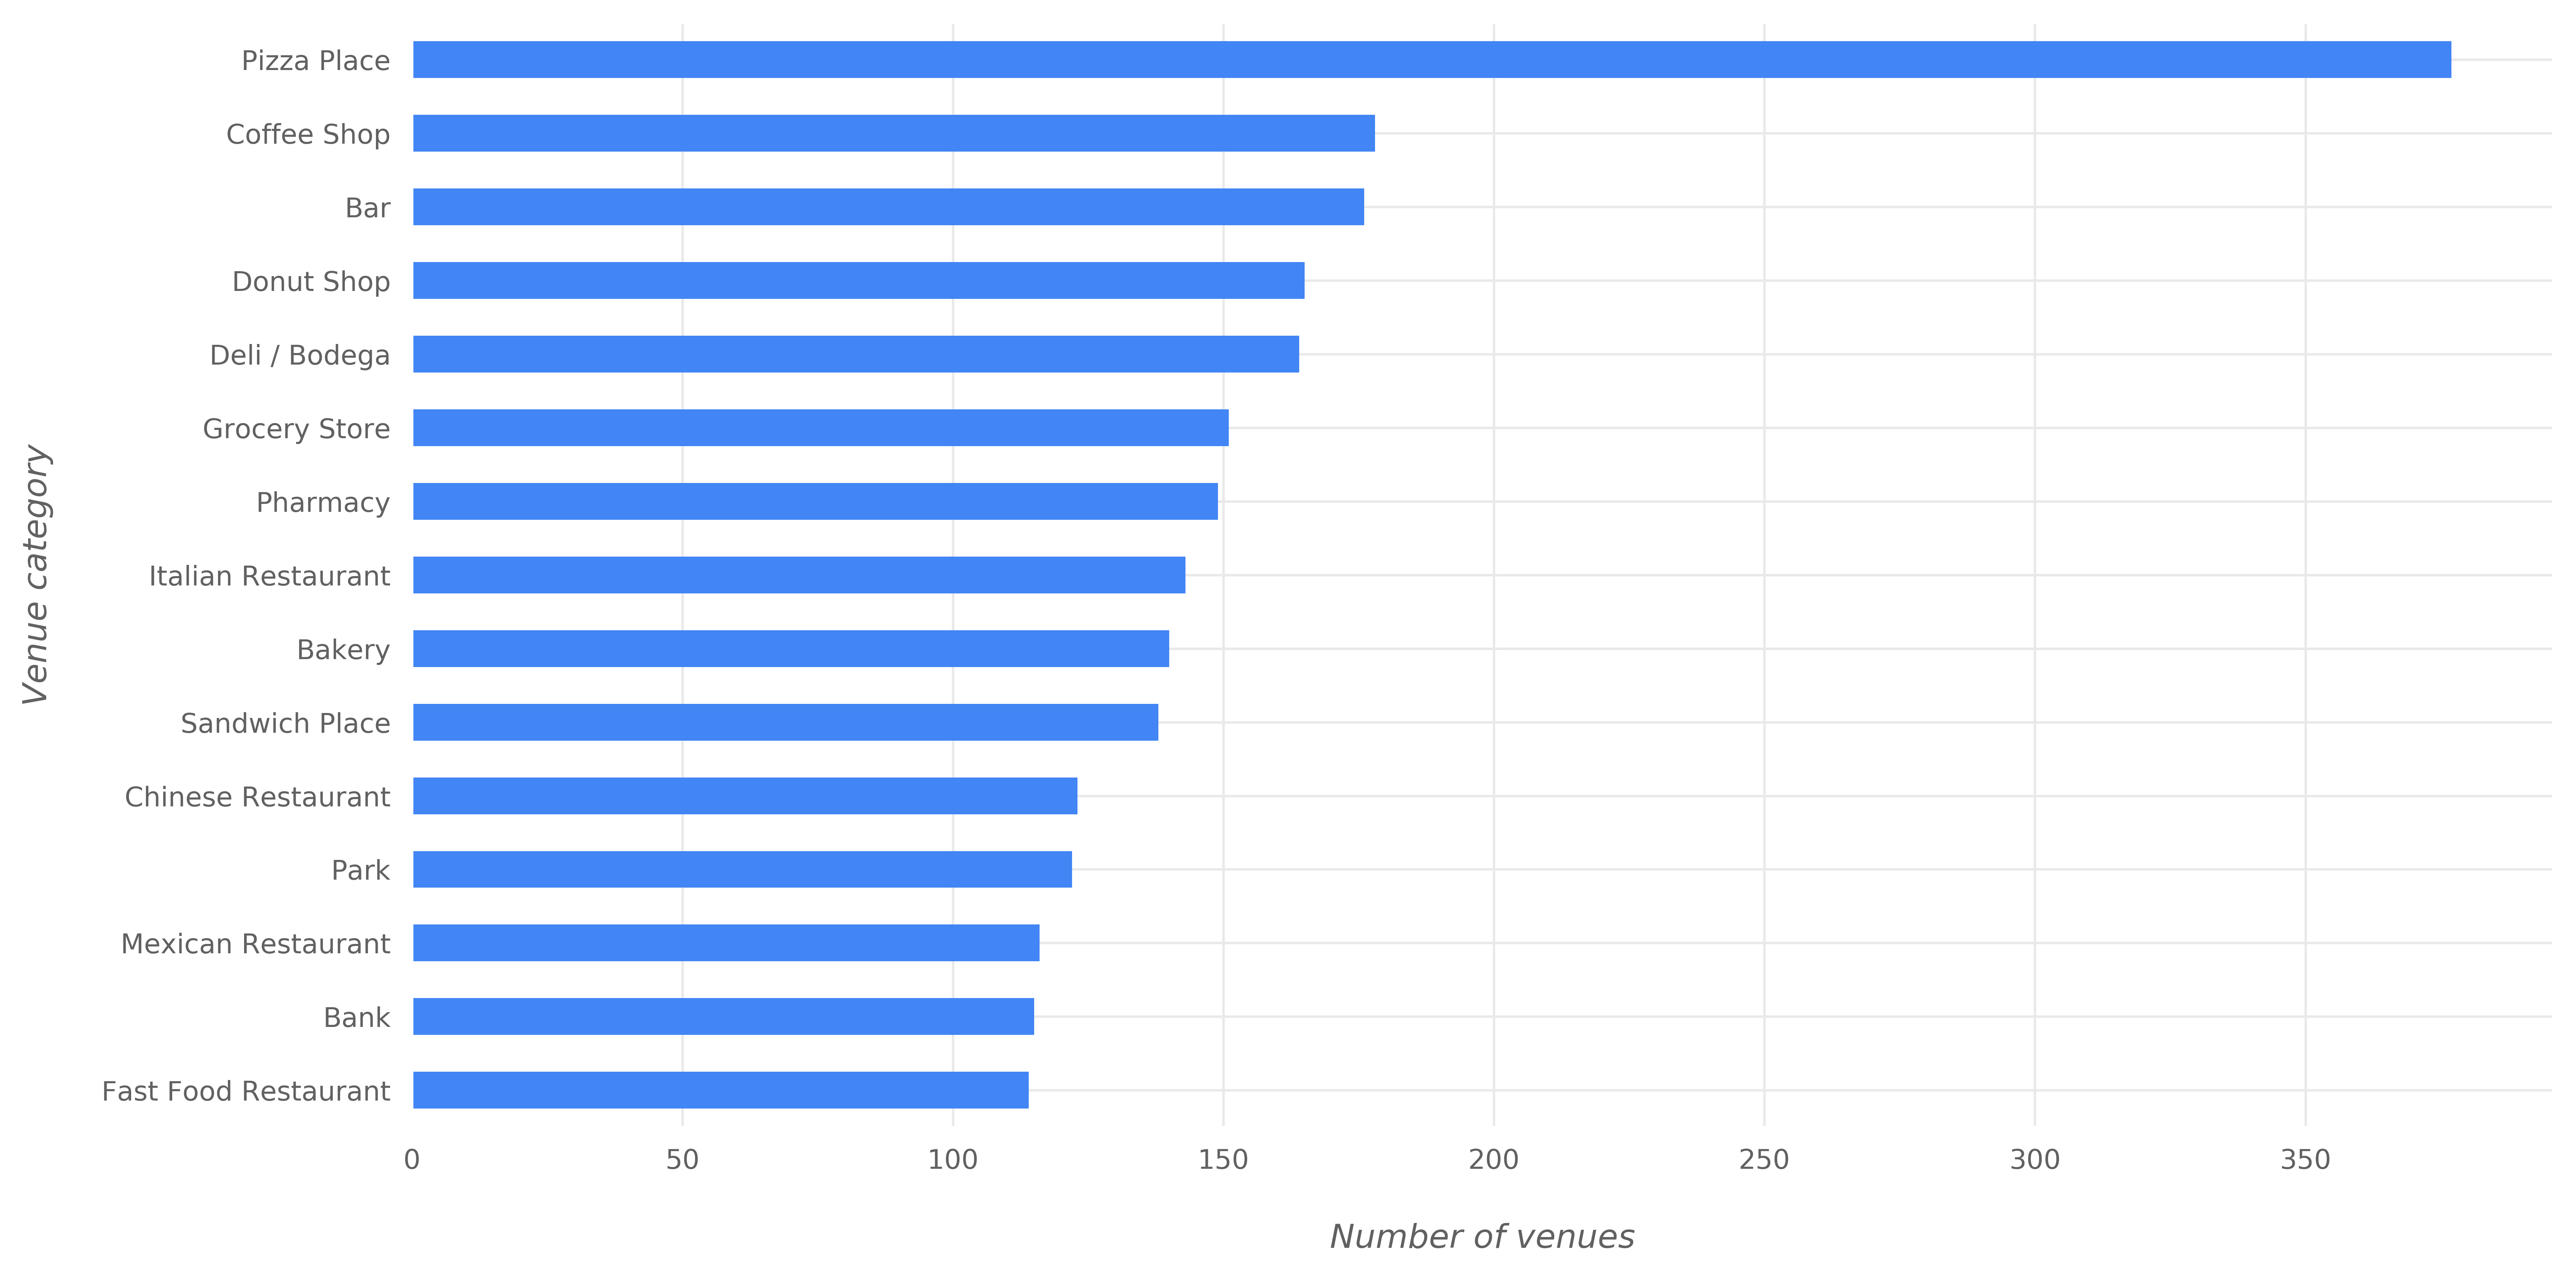

In [193]:

fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
nyc_top_vc = NYneighborhoods_venues['Venue Category'].value_counts(normalize=False)
ax = nyc_top_vc.head(15).plot(kind='barh', color=pc[0]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common-ven-nyc.png', dpi=300)


<h1>EDA</h1>

<h2>Most Common Venue Categories in NYC</h2>


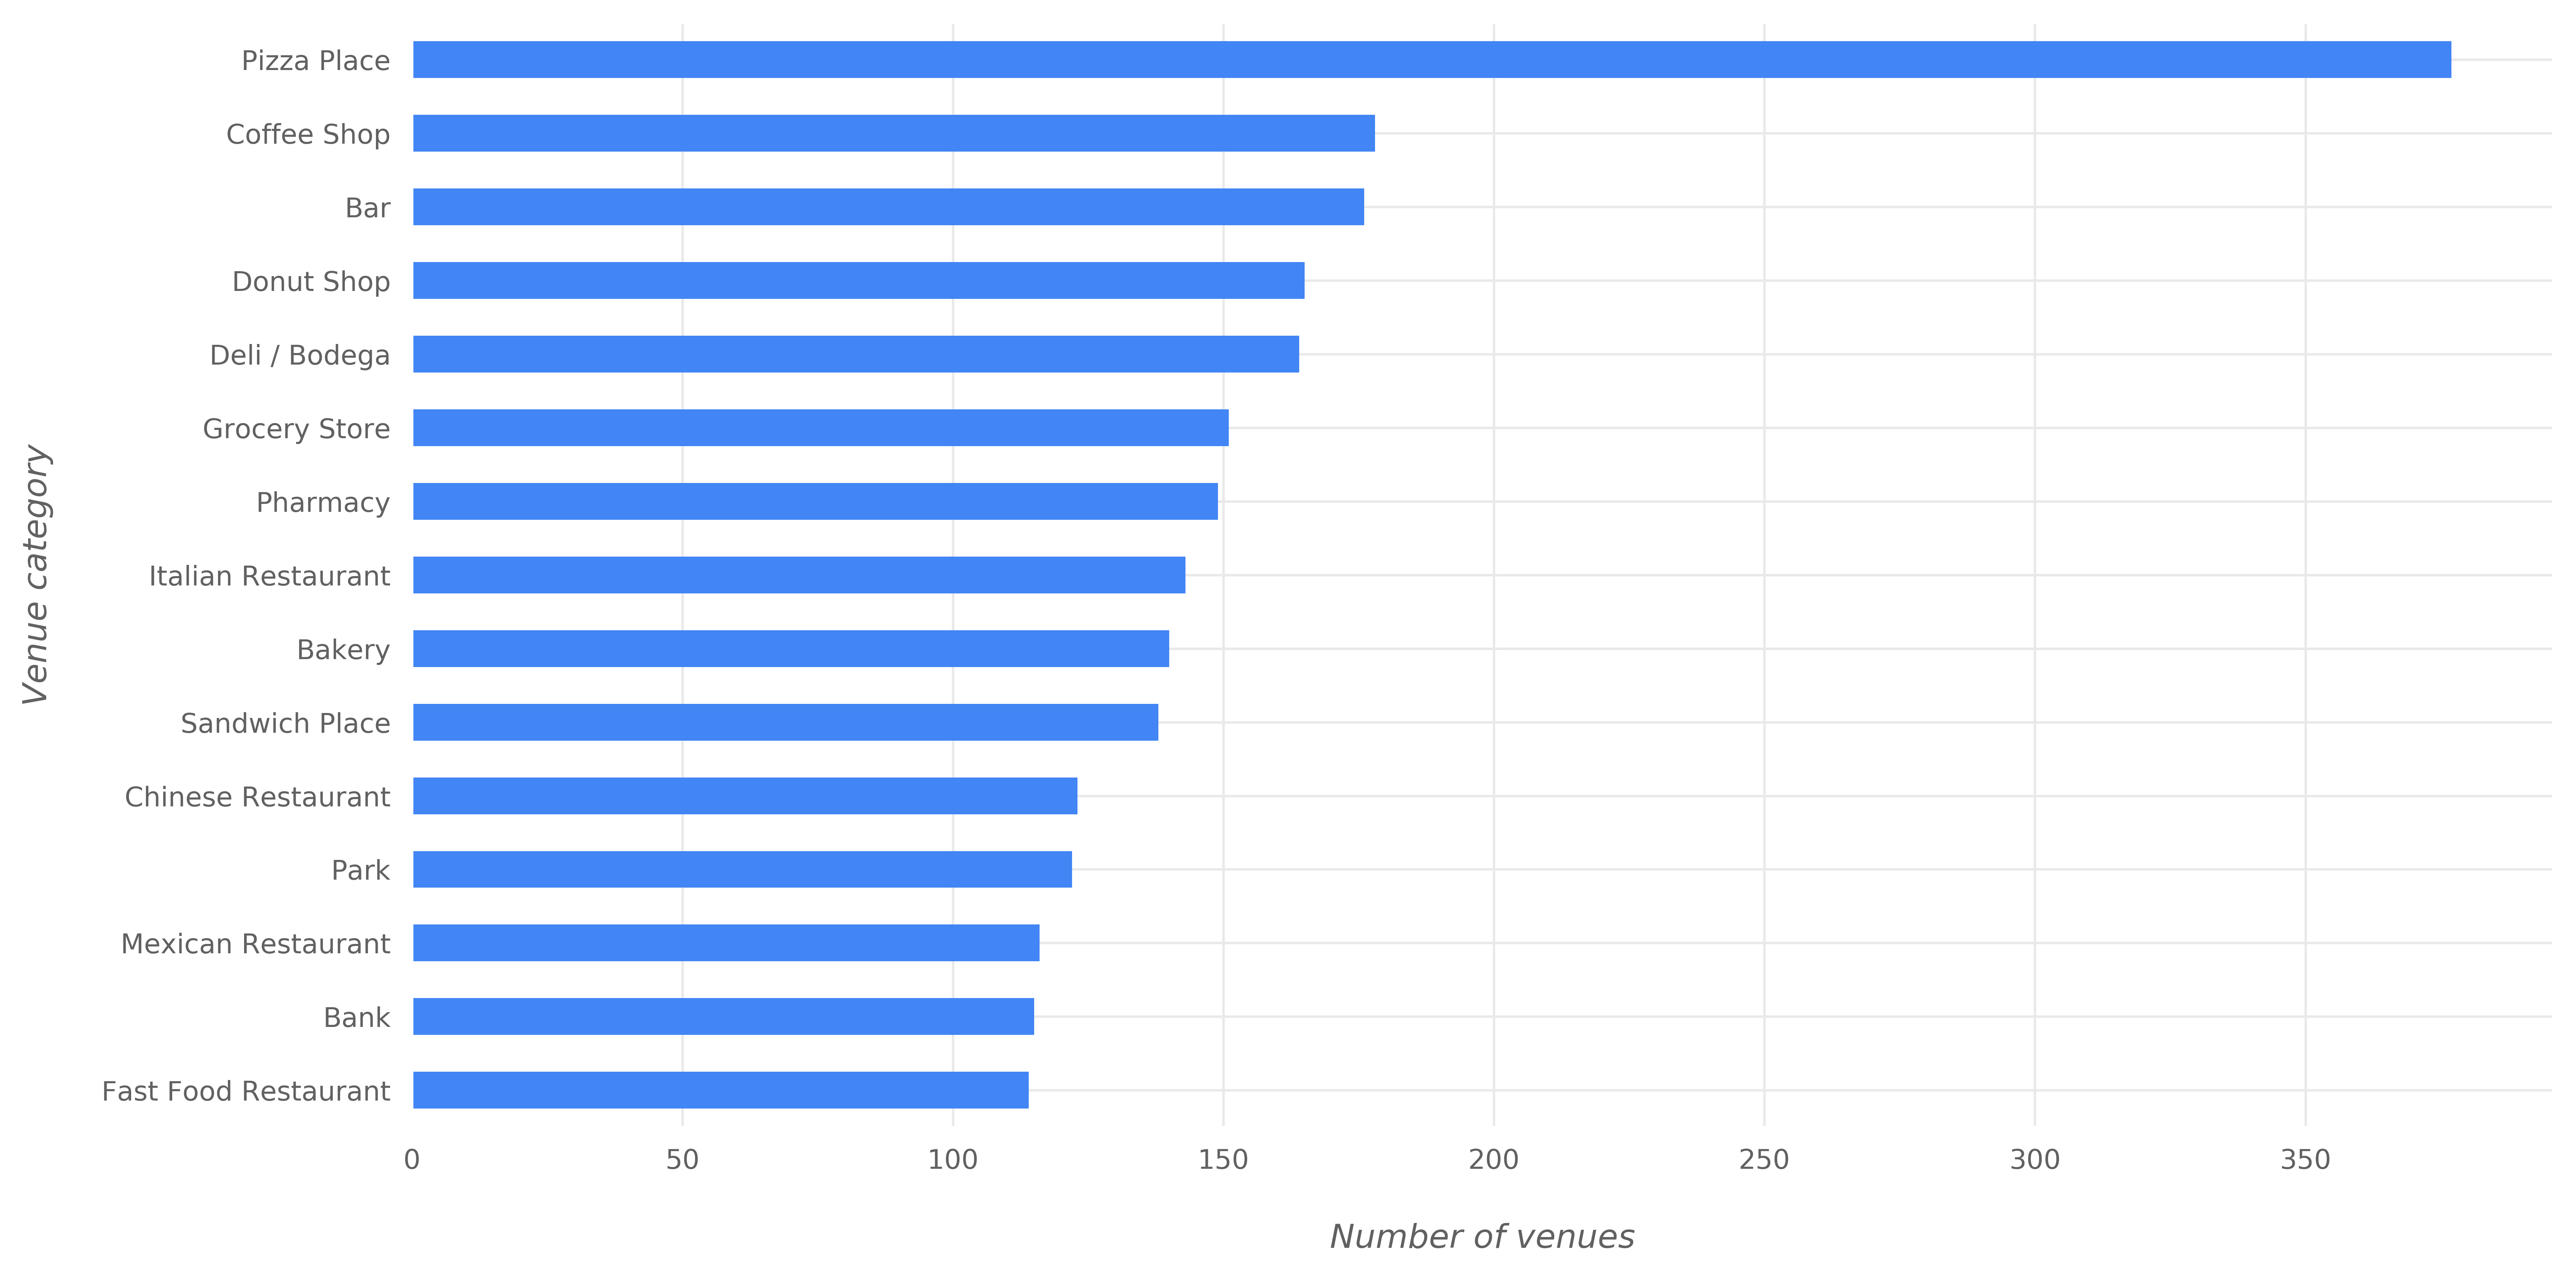

In [194]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
nyc_top_vc = NYneighborhoods_venues['Venue Category'].value_counts(normalize=False)
ax = nyc_top_vc.head(15).plot(kind='barh', color=pc[0]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common-ven-nyc.png', dpi=300)

<h2>Most Common Venue Categories in Toronto</h2>


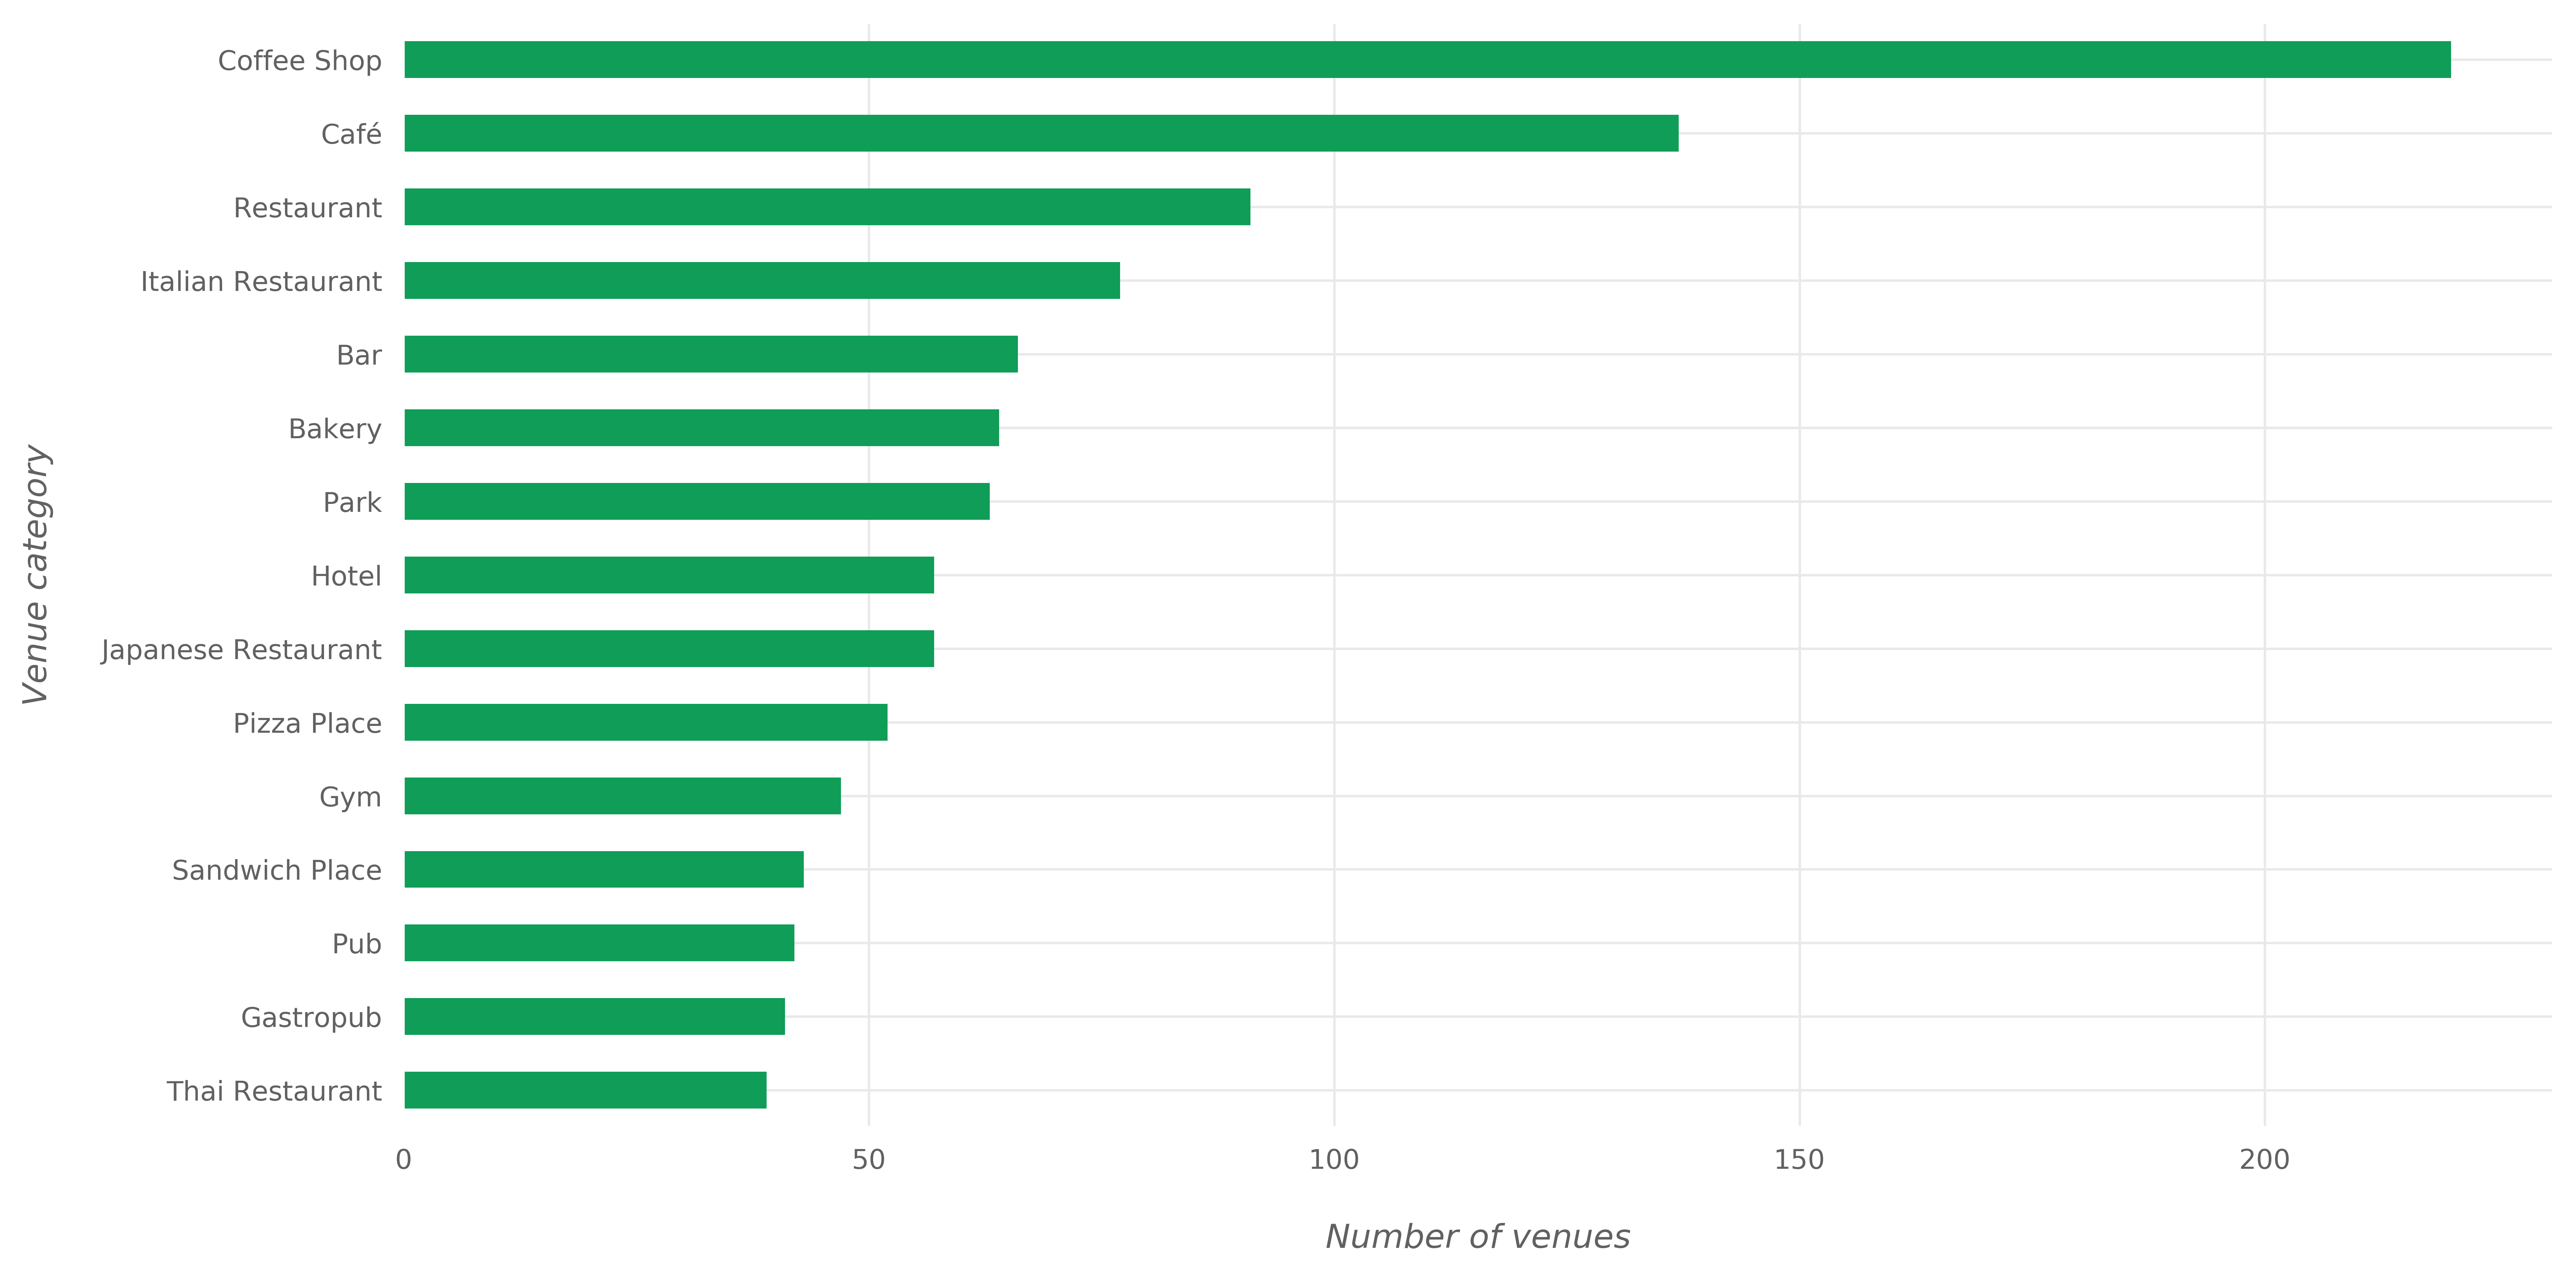

In [196]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
tor_top_vc = tor_venues['Venue Category'].value_counts(normalize=False)
ax = tor_top_vc.head(15).plot(kind='barh', color=pc[3]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common-ven-tor.png', dpi=300)

<h2>Which Venue Categories Exist in NYC Neighborhoods?  </h2>


122 neighborhoods in NYC


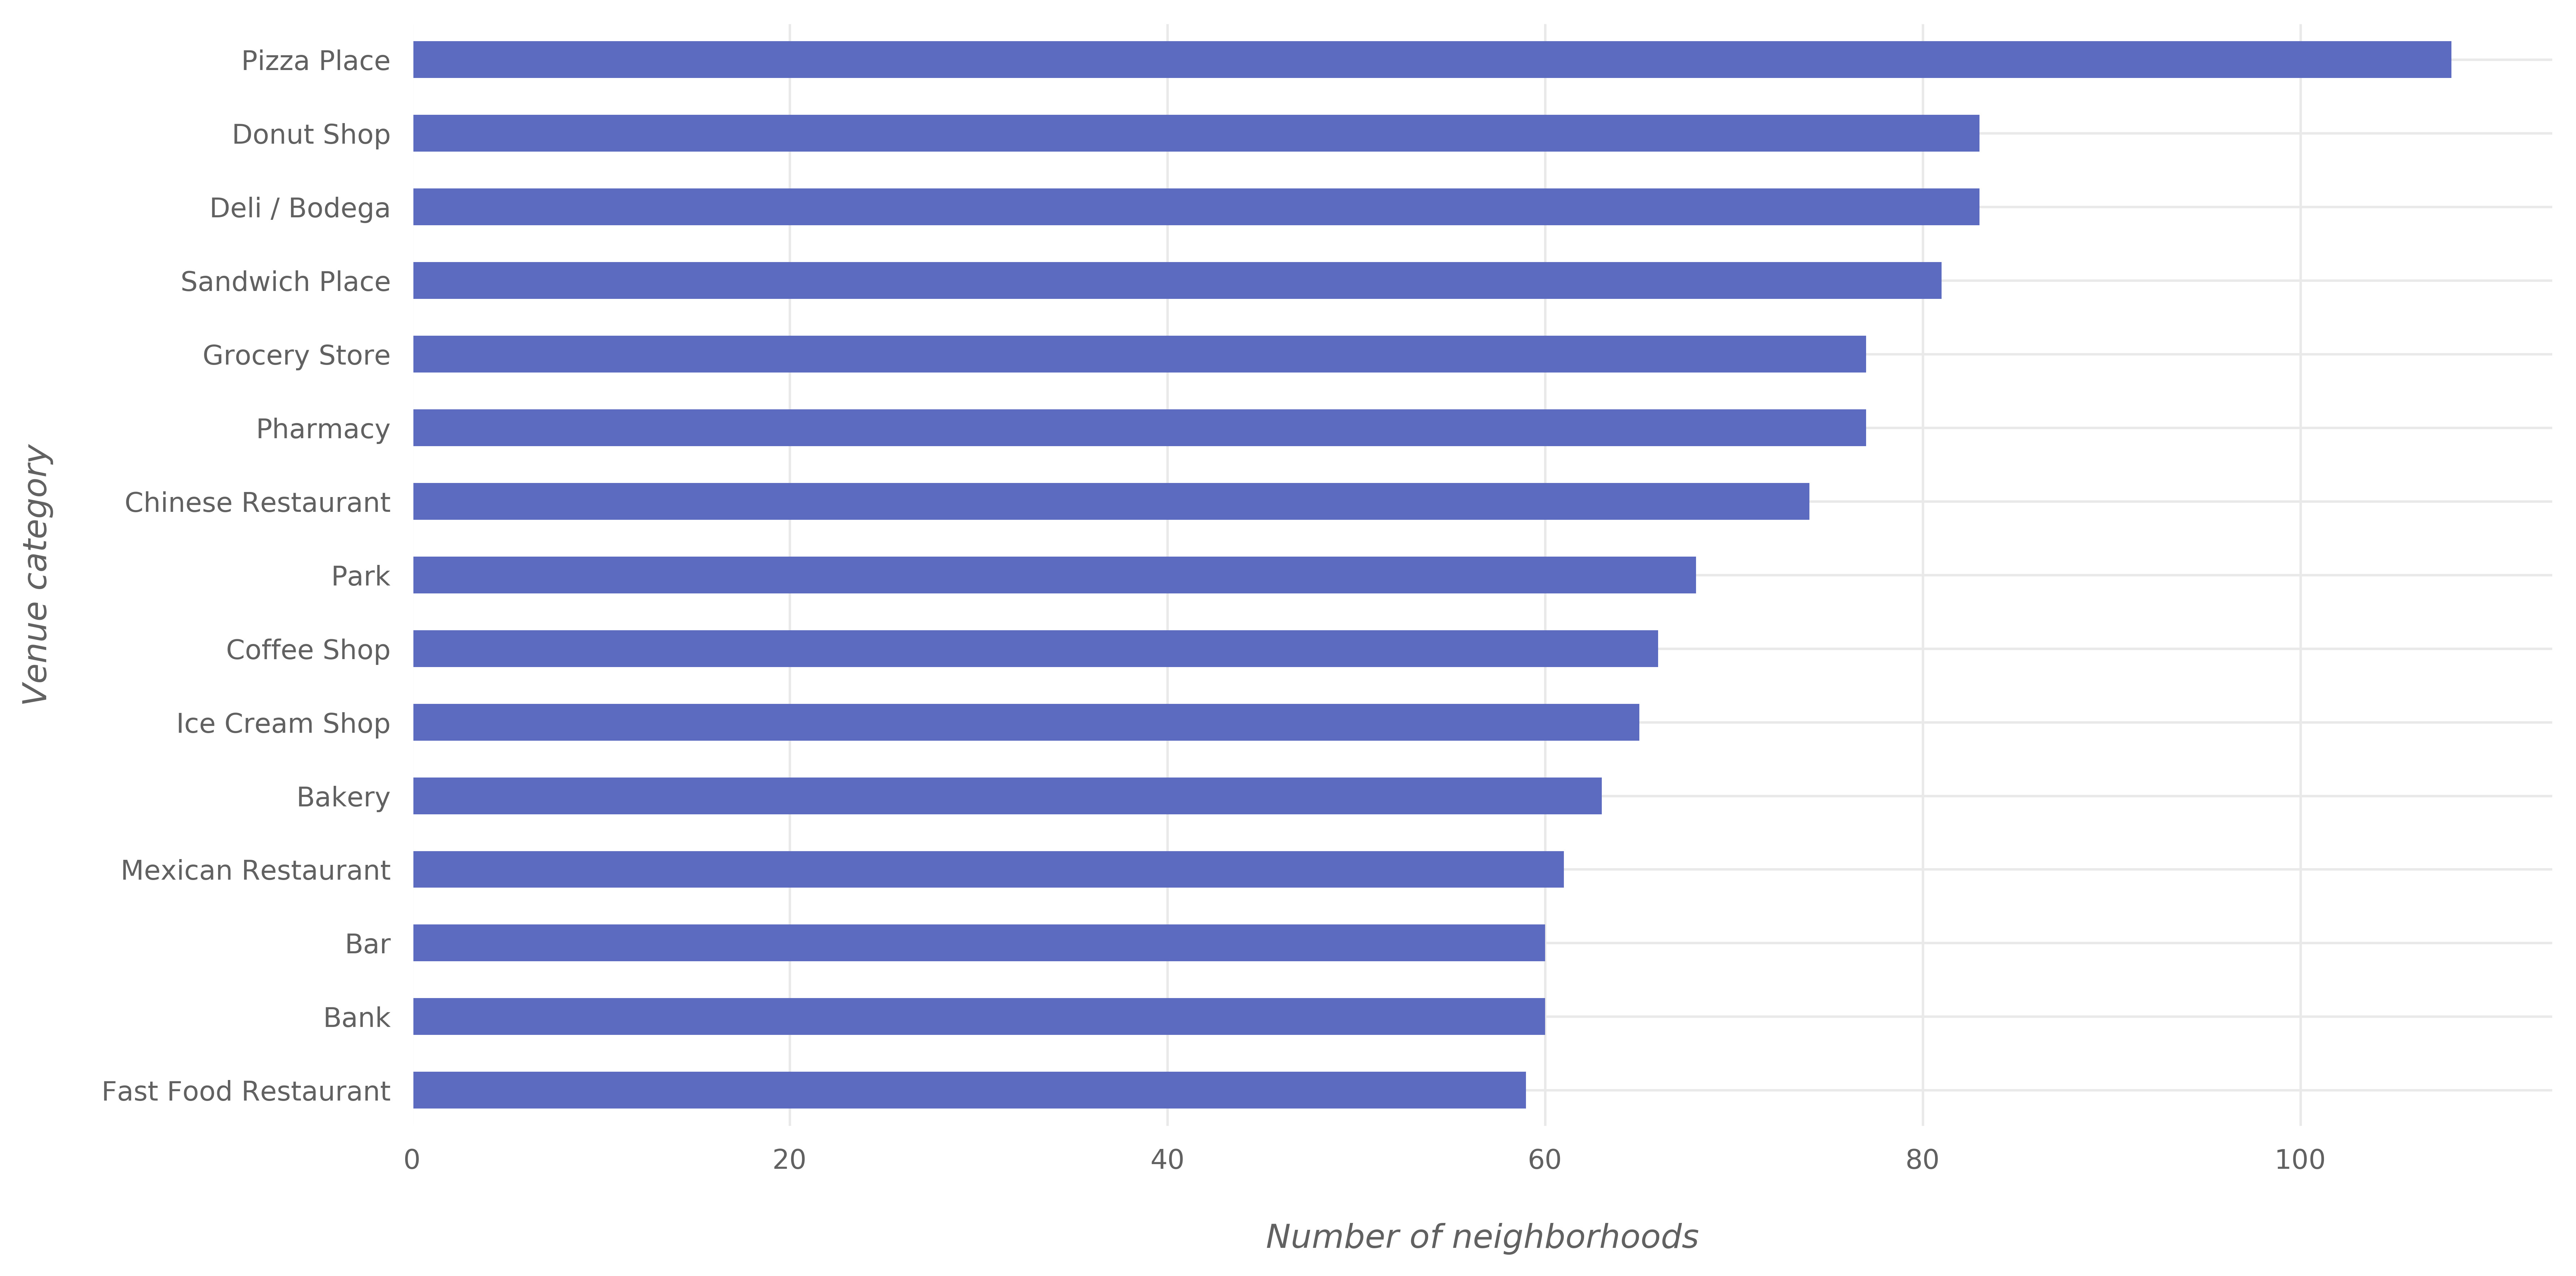

In [199]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
nyc_g = NYneighborhoods_onehot.groupby('Neighborhood').max().reset_index()
nyc_p = nyc_g.drop('Neighborhood', axis=1).sum().sort_values(ascending=False)
print("{} neighborhoods in NYC".format(nyc_g.shape[0]))
ax = nyc_p.head(15).plot(kind='barh', color=pc[8]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of neighborhoods', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common2-ven-nyc.png', dpi=300)

<h2>Which Venue Categories Exist in Toronto Neighborhoods?</h2>


39 neighborhoods in Toronto


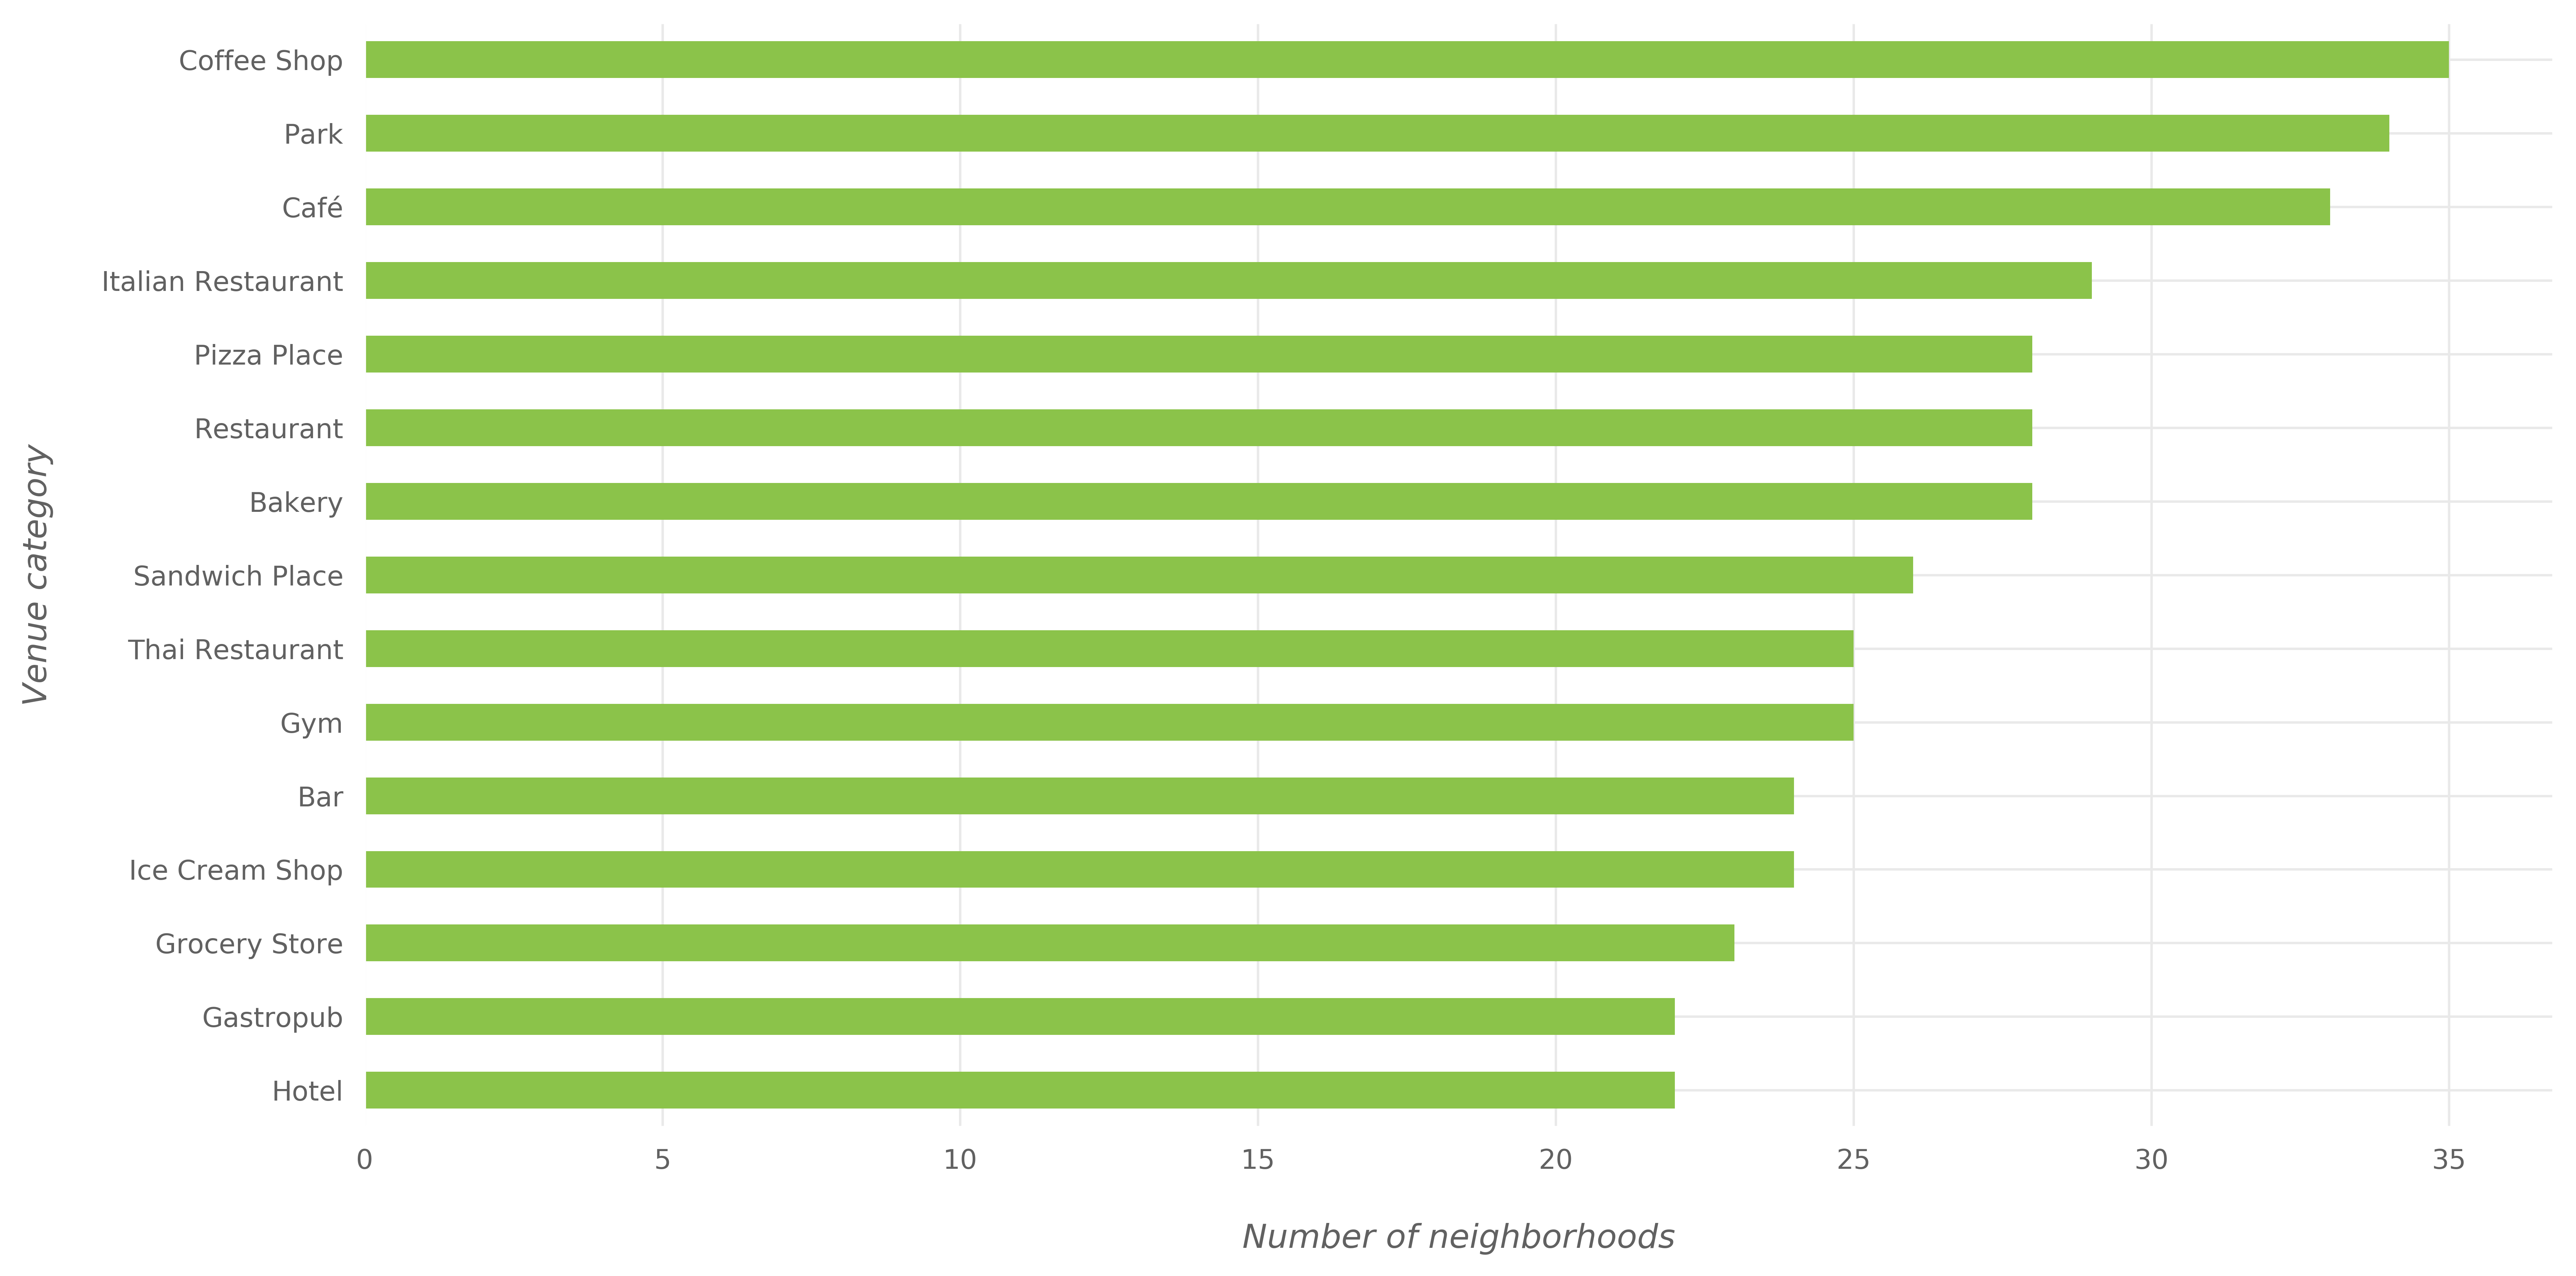

In [200]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
tor_g = tor_onehot.groupby('Neighborhood_').max().reset_index()
tor_p = tor_g.drop('Neighborhood_', axis=1).sum().sort_values(ascending=False)
print("{} neighborhoods in Toronto".format(tor_g.shape[0]))
ax = tor_p.head(15).plot(kind='barh', color=pc[14]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of neighborhoods', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common2-ven-tor.png', dpi=300)

<h2>Rare Categories in NYC</h2>


In [201]:
nyc_bot_vc = NYneighborhoods_venues['Venue Category'].value_counts(normalize=False)
nyc_bot_vc = nyc_bot_vc.tail(15).to_frame('Count')
nyc_bot_vc.index.names = ['Venue Category']
nyc_bot_vc

Count
Venue Category               
Memorial Site               1
Empanada Restaurant         1
Motel                       1
Varenyky restaurant         1
Winery                      1
Flea Market                 1
Waterfront                  1
Tailor Shop                 1
Laundry Service             1
Shopping Plaza              1
Music Store                 1
Austrian Restaurant         1
Shabu-Shabu Restaurant      1
Lake                        1
Tennis Stadium              1

<h2>Rare Categories in Toronto</h2>


In [142]:
tor_bot_vc = tor_venues['Venue Category'].value_counts(normalize=False)
tor_bot_vc = tor_bot_vc.tail(15).to_frame('Count')
tor_bot_vc.index.names = ['Venue Category']
tor_bot_vc

Count
Venue Category              
Coworking Space            1
Churrascaria               1
Soup Place                 1
Tanning Salon              1
IT Services                1
Cantonese Restaurant       1
Pool Hall                  1
Bed & Breakfast            1
Indonesian Restaurant      1
Belgian Restaurant         1
College Rec Center         1
Farm                       1
Theme Restaurant           1
River                      1
Dive Bar                   1

In [104]:
clmns_nyc_only = set(NYneighborhoods_grouped.columns).difference(set(tor_grouped.columns))
clmns_tor_only = set(tor_grouped.columns).difference(set(NYneighborhoods_grouped.columns))

tor_grouped.columns

Index(['Neighborhood_', 'Accessories Store', 'Afghan Restaurant', 'Airport',
       'Airport Food Court', 'Airport Gate', 'Airport Lounge',
       'Airport Service', 'Airport Terminal', 'American Restaurant',
       ...
       'University', 'Vegetarian / Vegan Restaurant', 'Video Game Store',
       'Video Store', 'Vietnamese Restaurant', 'Wine Bar', 'Wine Shop',
       'Wings Joint', 'Women's Store', 'Yoga Studio'],
      dtype='object', length=283)

In [223]:
clmns_nyc_only

{'African Restaurant',
 'Arcade',
 'Arepa Restaurant',
 'Argentinian Restaurant',
 'Austrian Restaurant',
 'Auto Dealership',
 'Auto Garage',
 'Automotive Shop',
 'Basketball Court',
 'Bath House',
 'Beer Garden',
 'Big Box Store',
 'Bike Rental / Bike Share',
 'Bike Trail',
 'Board Shop',
 'Border Crossing',
 'Botanical Garden',
 'Bowling Alley',
 'Boxing Gym',
 'Bridal Shop',
 'Bridge',
 'Buffet',
 'Caucasian Restaurant',
 'Check Cashing Service',
 'College Academic Building',
 'College Bookstore',
 'Community Center',
 'Construction & Landscaping',
 'Convention Center',
 'Cruise',
 'Cycle Studio',
 'Distillery',
 'Dry Cleaner',
 'Empanada Restaurant',
 'Entertainment Service',
 'Event Service',
 'Exhibit',
 'Factory',
 'Field',
 'Film Studio',
 'Financial or Legal Service',
 'Fishing Spot',
 'Fishing Store',
 'Go Kart Track',
 'Golf Course',
 'Gymnastics Gym',
 'Halal Restaurant',
 'Herbs & Spices Store',
 'High School',
 'Hobby Shop',
 'Home Service',
 'Hookah Bar',
 'Indie Theater

In [224]:
clmns_tor_only

{'Afghan Restaurant',
 'Airport',
 'Airport Food Court',
 'Airport Gate',
 'Airport Lounge',
 'Airport Service',
 'Airport Terminal',
 'Amphitheater',
 'Aquarium',
 'Baby Store',
 'Beach Bar',
 'Bed & Breakfast',
 'Belgian Restaurant',
 'Castle',
 'Chiropractor',
 'Churrascaria',
 'College Arts Building',
 'College Gym',
 'College Rec Center',
 'College Theater',
 'Costume Shop',
 'Curling Ice',
 'Design Studio',
 'Distribution Center',
 'Doner Restaurant',
 'Festival',
 'Fountain',
 'General Travel',
 'Gluten-free Restaurant',
 'Hawaiian Restaurant',
 'Hotel Bar',
 'IT Services',
 'Indian Chinese Restaurant',
 'Indonesian Restaurant',
 'Jewish Restaurant',
 'Light Rail Station',
 'Modern European Restaurant',
 'Molecular Gastronomy Restaurant',
 'Music School',
 'Neighborhood_',
 'Pastry Shop',
 'Portuguese Restaurant',
 'Poutine Place',
 'Swim School',
 'Syrian Restaurant',
 'Tanning Salon',
 'Tech Startup',
 'Theme Restaurant',
 'Tram Station',
 'Tunnel',
 'Udon Restaurant',
 'Unive

In [109]:
nyc_grouped_ = NYneighborhoods_grouped.copy()

nyc_grouped_['Neighborhood_'] = nyc_grouped_['Neighborhood_'].apply(lambda x: x + '_NY')

#nyc_grouped_

tor_grouped_ = tor_grouped.copy()
tor_grouped_['Neighborhood_'] = tor_grouped_['Neighborhood_'].apply(lambda x: x + '_TOR')
#tor_grouped_

for c in clmns_tor_only:
    nyc_grouped_[c] = 0
for c in clmns_nyc_only:
    tor_grouped_[c] = 0


all_clmns_sorted = ['Neighborhood_'] + sorted(list(nyc_grouped_.drop('Neighborhood_', axis=1).columns), key=str.lower)
all_clmns_sorted
nyc_grouped_ = nyc_grouped_[all_clmns_sorted]
tor_grouped_ = tor_grouped_[all_clmns_sorted]
    
#nyc_tor_grouped = pd.concat([nyc_grouped_, tor_grouped_]).reset_index(drop=True)


In [111]:
nyc_tor_grouped.loc[300:310,]

Neighborhood_  Accessories Store  \
300                                         Wingate_NY           0.000000   
301                                       Woodhaven_NY           0.000000   
302                                        Woodlawn_NY           0.000000   
303                                         Woodrow_NY           0.000000   
304                                        Woodside_NY           0.000000   
305                                       Yorkville_NY           0.000000   
306                       Adelaide, King, Richmond_TOR           0.000000   
307                                    Berczy Park_TOR           0.000000   
308   Brockton, Exhibition Place, Parkdale Village_TOR           0.011905   
309  Business Reply Mail Processing Centre 969 East...           0.000000   
310  CN Tower, Bathurst Quay, Island airport, Harbo...           0.000000   

     Adult Boutique  Afghan Restaurant  African Restaurant   Airport  \
300             0.0                0.0                 0.0  0.000000   
301             0.0                0.0                 0.0  0.000000   
302             0.0                0.0                 0.0  0.000000   
303             0.0                0.0                 0.0  0.000000   
304             0.0                0.0                 0.0  0.000000   
305             0.0                0.0                 0.0  0.000000   
306             0.0                0.0                 0.0  0.000000   
307             0.0                0.0                 0.0  0.000000   
308             0.0                0.0                 0.0  0.000000   
309             0.0                0.0                 0.0  0.000000   
310             0.0                0.0                 0.0  0.038462   

     Airport Food Court  Airport Gate  Airport Lounge  Airport Service  ...  \
300            0.000000      0.000000        0.000000         0.000000  ...   
301            0.000000      0.000000        0.000000         0.000000  ...   
302            0.000000      0.000000        0.000000         0.000000  ...   
303            0.000000      0.000000        0.000000         0.000000  ...   
304            0.000000      0.000000        0.000000         0.000000  ...   
305            0.000000      0.000000        0.000000         0.000000  ...   
306            0.000000      0.000000        0.000000         0.000000  ...   
307            0.000000      0.000000        0.000000         0.000000  ...   
308            0.000000      0.000000        0.000000         0.000000  ...   
309            0.000000      0.000000        0.000000         0.000000  ...   
310            0.038462      0.038462        0.076923         0.076923  ...   

     Weight Loss Center  Whisky Bar  Wine Bar  Wine Shop  Winery  Wings Joint  \
300                 0.0         0.0  0.000000   0.000000     0.0     0.021739   
301                 0.0         0.0  0.000000   0.000000     0.0     0.000000   
302                 0.0         0.0  0.000000   0.000000     0.0     0.000000   
303                 0.0         0.0  0.000000   0.000000     0.0     0.000000   
304                 0.0         0.0  0.000000   0.000000     0.0     0.000000   
305                 0.0         0.0  0.010000   0.020000     0.0     0.000000   
306                 0.0         0.0  0.010101   0.000000     0.0     0.000000   
307                 0.0         0.0  0.000000   0.000000     0.0     0.000000   
308                 0.0         0.0  0.000000   0.000000     0.0     0.000000   
309                 0.0         0.0  0.000000   0.019231     0.0     0.000000   
310                 0.0         0.0  0.000000   0.000000     0.0     0.000000   

     Women's Store  Yoga Studio  Zoo  Zoo Exhibit  
300            0.0     0.000000  0.0          0.0  
301            0.0     0.000000  0.0          0.0  
302            0.0     0.000000  0.0          0.0  
303            0.0     0.000000  0.0          0.0  
304            0.0     0.000000  0.0          0.0  
305            0.

In [112]:
nyc_tor_grouped.shape

(345, 485)

In [113]:
# obtaining the most popular categories for each neighborhood

nyc_tor_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
nyc_tor_neighborhoods_categories_sorted['Neighborhood_'] = nyc_tor_grouped['Neighborhood_']

for ind in np.arange(nyc_tor_grouped.shape[0]):
    nyc_tor_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_tor_grouped.iloc[ind, :], num_top_cat)

nyc_tor_neighborhoods_categories_sorted.head()

Neighborhood_ 1st Most Common Category 2nd Most Common Category  \
0       Allerton_NY              Pizza Place               Donut Shop   
1       Annadale_NY              Pizza Place               Restaurant   
2  Arden Heights_NY                     Food       Mexican Restaurant   
3      Arlington_NY            Deli / Bodega             Intersection   
4       Arrochar_NY            Deli / Bodega                    Beach   

  3rd Most Common Category 4th Most Common Category 5th Most Common Category  \
0           Sandwich Place                 Pharmacy       Chinese Restaurant   
1                    Diner               Sports Bar                 Pharmacy   
2             Optical Shop            Deli / Bodega              Pizza Place   
3         Business Service              Supermarket            Grocery Store   
4              Pizza Place           Baseball Field       Italian Restaurant   

  6th Most Common Category  7th Most Common Category  
0     Fast Food Restaurant            Discount Store  
1             Dance Studio             Train Station  
2        Elementary School            Sandwich Place  
3                     Tree             Boat or Ferry  
4        Martial Arts Dojo  Mediterranean Restaurant

In [114]:
nyc_tor_bot_vc = pd.concat([NYneighborhoods_venues, tor_venues])['Venue Category'].value_counts(normalize=False)
nyc_tor_bot_vc = nyc_tor_bot_vc.tail(15).to_frame('Count')
nyc_tor_bot_vc.index.names = ['Venue Category']
nyc_tor_bot_vc

Count
Venue Category            
Campground               1
Child Care Service       1
Food Stand               1
IT Services              1
Syrian Restaurant        1
University               1
Piano Bar                1
Auto Workshop            1
Airport Gate             1
Duty-free Shop           1
Platform                 1
Indoor Play Area         1
Bed & Breakfast          1
Leather Goods Store      1
Winery                   1

In [115]:
# the number of clusters
kclusters = 5

nyc_tor_grouped_clustering = nyc_tor_grouped.drop('Neighborhood_', 1)
nyc_tor_grouped_clustering
# run k-means clustering

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_tor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


array([2, 2, 2, 2, 2, 2, 0, 0, 2, 2], dtype=int32)

In [116]:
# add clustering labels
nyc_tor_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# nyc_tor_merged = nyc_tor_neighborhoods.rename(columns={'Neighborhood': 'Neighborhood_'}).copy()
# tor_merged = tor_merged[~tor_merged['Neighborhood_'].isin(tor_excluded_neighborhoods)]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
nyc_tor_merged = nyc_tor_neighborhoods_categories_sorted.set_index('Neighborhood_')

nyc_tor_merged.iloc[300:310] # check the last columns!

Cluster Labels  \
Neighborhood_                                                        
Wingate_NY                                                       2   
Woodhaven_NY                                                     2   
Woodlawn_NY                                                      2   
Woodrow_NY                                                       2   
Woodside_NY                                                      0   
Yorkville_NY                                                     0   
Adelaide, King, Richmond_TOR                                     0   
Berczy Park_TOR                                                  0   
Brockton, Exhibition Place, Parkdale Village_TOR                 0   
Business Reply Mail Processing Centre 969 Easte...               0   

                                                   1st Most Common Category  \
Neighborhood_                                                                 
Wingate_NY                                                      Pizza Place   
Woodhaven_NY                                                  Deli / Bodega   
Woodlawn_NY                                                             Pub   
Woodrow_NY                                                    Grocery Store   
Woodside_NY                                                 Thai Restaurant   
Yorkville_NY                                                            Gym   
Adelaide, King, Richmond_TOR                                    Coffee Shop   
Berczy Park_TOR                                                 Coffee Shop   
Brockton, Exhibition Place, Parkdale Village_TOR                Coffee Shop   
Business Reply Mail Processing Centre 969 Easte...     Fast Food Restaurant   

                                                     2nd Most Common Category  \
Neighborhood_                                                                   
Wingate_NY                                                         Donut Shop   
Woodhaven_NY                                        Latin American Restaurant   
Woodlawn_NY                                                               Bar   
Woodrow_NY                                                         Donut Shop   
Woodside_NY                                                               Bar   
Yorkville_NY                                               Italian Restaurant   
Adelaide, King, Richmond_TOR                                             Café   
Berczy Park_TOR                                                         Hotel   
Brockton, Exhibition Place, Parkdale Village_TOR                         Café   
Business Reply Mail Processing Centre 969 Easte...                        Bar   

                                                   3rd Most Common Category  \
Neighborhood_                                                                 
Wingate_NY                                                    Deli / Bodega   
Woodhaven_NY                                                    Pizza Place   
Woodlawn_NY                                                   Deli / Bodega   
Woodrow_NY                                                            Diner   
Woodside_NY                                                   Grocery Store   
Yorkville_NY                                                    Coffee Shop   
Adelaide, King, Richmond_TOR                                     Restaurant   
Berczy Park_TOR                                                        Café   
Brockton, Exhibition Place, Parkdale Village_TOR                  Gift Shop   
Business Reply Mail Processing Centre 969 Easte...                     Park   

                                                     4th Most Common Category  \
Neighborhood_                                                                   
Wingate_NY                                                      Grocery Store   
Woodhaven_NY                                                         Pharmacy   
Woodlawn_NY     

In [ ]:
Cluster 1

In [147]:
c1 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 0, :]
print(c1.shape)
c1.iloc[60:70]

(162, 8)


Cluster Labels 1st Most Common Category  \
Neighborhood_                                                  
Lighthouse Hill_NY                0                    Trail   
Lincoln Square_NY                 0                    Plaza   
Little Italy_NY                   0       Italian Restaurant   
Little Neck_NY                    0       Italian Restaurant   
Long Island City_NY               0                    Hotel   
Lower East Side_NY                0              Art Gallery   
Manhattan Beach_NY                0          Harbor / Marina   
Manhattan Valley_NY               0                     Park   
Manhattanville_NY                 0       Chinese Restaurant   
Midtown_NY                        0              Coffee Shop   

                    2nd Most Common Category 3rd Most Common Category  \
Neighborhood_                                                           
Lighthouse Hill_NY            Clothing Store               Bagel Shop   
Lincoln Square_NY         Italian Restaurant                  Theater   
Little Italy_NY               Cosmetics Shop                     Café   
Little Neck_NY            Chinese Restaurant                     Bank   
Long Island City_NY              Coffee Shop              Pizza Place   
Lower East Side_NY            Ice Cream Shop       Mexican Restaurant   
Manhattan Beach_NY              Dessert Shop       Turkish Restaurant   
Manhattan Valley_NY        Indian Restaurant              Coffee Shop   
Manhattanville_NY                       Park       Mexican Restaurant   
Midtown_NY                             Hotel                    Plaza   

                    4th Most Common Category 5th Most Common Category  \
Neighborhood_                                                           
Lighthouse Hill_NY                       Spa                     Café   
Lincoln Square_NY          French Restaurant             Concert Hall   
Little Italy_NY               Ice Cream Shop             Cocktail Bar   
Little Neck_NY                   Coffee Shop                   Bakery   
Long Island City_NY       Mexican Restaurant     Gym / Fitness Center   
Lower East Side_NY               Coffee Shop      Japanese Restaurant   
Manhattan Beach_NY                Restaurant       Seafood Restaurant   
Manhattan Valley_NY              Pizza Place       Chinese Restaurant   
Manhattanville_NY         Italian Restaurant              Coffee Shop   
Midtown_NY                       Pizza Place      Japanese Restaurant   

                      6th Most Common Category 7th Most Common Category  
Neighborhood_                                                            
Lighthouse Hill_NY              History Museum               Art Museum  
Lincoln Square_NY         Gym / Fitness Center                     Park  
Little Italy_NY                 Sandwich Place                    Hotel  
Little Neck_NY       Middle Eastern Restaurant        Mobile Phone Shop  
Long Island City_NY            Bubble Tea Shop        Indian Restaurant  
Lower East Side_NY            Asian Restaurant              Pizza Place  
Manhattan Beach_NY                        Lake           Sandwich Place  
Manhattan Valley_NY                        Bar                Wine Shop  
Manhattanville_NY                  Pizza Place                     Café  
Midtown_NY                      Sandwich Place                   Bakery

In [ ]:
Cluster 2

In [148]:
c2 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 1, :]
print(c2.shape)
c2

(1, 8)


Cluster Labels 1st Most Common Category  \
Neighborhood_                                            
Todt Hill_NY                1                 Mountain   

              2nd Most Common Category 3rd Most Common Category  \
Neighborhood_                                                     
Todt Hill_NY               Zoo Exhibit                 Festival   

              4th Most Common Category 5th Most Common Category  \
Neighborhood_                                                     
Todt Hill_NY        English Restaurant    Entertainment Service   

              6th Most Common Category 7th Most Common Category  
Neighborhood_                                                    
Todt Hill_NY      Ethiopian Restaurant            Event Service

In [ ]:
Cluster 3

In [149]:
c3 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 2, :]
print(c3.shape)
c3.tail()

(170, 8)


Cluster Labels 1st Most Common Category  \
Neighborhood_                                             
Willowbrook_NY               2               Bagel Shop   
Wingate_NY                   2              Pizza Place   
Woodhaven_NY                 2            Deli / Bodega   
Woodlawn_NY                  2                      Pub   
Woodrow_NY                   2            Grocery Store   

                 2nd Most Common Category 3rd Most Common Category  \
Neighborhood_                                                        
Willowbrook_NY         Chinese Restaurant              Pizza Place   
Wingate_NY                     Donut Shop            Deli / Bodega   
Woodhaven_NY    Latin American Restaurant              Pizza Place   
Woodlawn_NY                           Bar            Deli / Bodega   
Woodrow_NY                     Donut Shop                    Diner   

               4th Most Common Category 5th Most Common Category  \
Neighborhood_                                                      
Willowbrook_NY              Zoo Exhibit           Farmers Market   
Wingate_NY                Grocery Store      Fried Chicken Joint   
Woodhaven_NY                   Pharmacy              Supermarket   
Woodlawn_NY                 Pizza Place       Italian Restaurant   
Woodrow_NY                         Bank                   Bakery   

               6th Most Common Category 7th Most Common Category  
Neighborhood_                                                     
Willowbrook_NY       English Restaurant    Entertainment Service  
Wingate_NY                     Pharmacy           Sandwich Place  
Woodhaven_NY        Fried Chicken Joint           Sandwich Place  
Woodlawn_NY              Discount Store            Grocery Store  
Woodrow_NY                         Park             Liquor Store

In [ ]:
Cluster 4

In [121]:
c4 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 3, :]
print(c4.shape)
c4

(6, 8)


Cluster Labels 1st Most Common Category  \
Neighborhood_                                               
Belle Harbor_NY                3                    Beach   
Butler Manor_NY                3           Baseball Field   
Midland Beach_NY               3                    Beach   
Neponsit_NY                    3                    Beach   
Sea Gate_NY                    3                    Beach   
South Beach_NY                 3                    Beach   

                 2nd Most Common Category    3rd Most Common Category  \
Neighborhood_                                                           
Belle Harbor_NY                       Spa                         Pub   
Butler Manor_NY         Convenience Store                        Pool   
Midland Beach_NY           Baseball Field                  Restaurant   
Neponsit_NY                          Park                 Pizza Place   
Sea Gate_NY                   Supermarket  Construction & Landscaping   
South Beach_NY                       Pier                Soccer Field   

                 4th Most Common Category 5th Most Common Category  \
Neighborhood_                                                        
Belle Harbor_NY             Deli / Bodega               Donut Shop   
Butler Manor_NY               Zoo Exhibit     Fast Food Restaurant   
Midland Beach_NY     Other Great Outdoors                Pet Store   
Neponsit_NY                   Zoo Exhibit           Farmers Market   
Sea Gate_NY           American Restaurant              Pizza Place   
South Beach_NY         Athletics & Sports      American Restaurant   

                 6th Most Common Category 7th Most Common Category  
Neighborhood_                                                       
Belle Harbor_NY                    Bakery               Bagel Shop  
Butler Manor_NY        English Restaurant    Entertainment Service  
Midland Beach_NY             Liquor Store                Bookstore  
Neponsit_NY            English Restaurant    Entertainment Service  
Sea Gate_NY                           Spa                     Park  
South Beach_NY              Deli / Bodega               Skate Park

In [ ]:
Cluster 5

In [120]:
c5 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 4, :]
print(c5.shape)
c5

(6, 8)


Cluster Labels  \
Neighborhood_                                             
Bayswater_NY                                          4   
Clason Point_NY                                       4   
Howland Hook_NY                                       4   
Malba_NY                                              4   
Forest Hill North, Forest Hill West_TOR               4   
Rosedale_TOR                                          4   

                                        1st Most Common Category  \
Neighborhood_                                                      
Bayswater_NY                                          Playground   
Clason Point_NY                                             Park   
Howland Hook_NY                                  Harbor / Marina   
Malba_NY                                                    Park   
Forest Hill North, Forest Hill West_TOR                     Park   
Rosedale_TOR                                                Park   

                                           2nd Most Common Category  \
Neighborhood_                                                         
Bayswater_NY                             Construction & Landscaping   
Clason Point_NY                                       Boat or Ferry   
Howland Hook_NY                                              Resort   
Malba_NY                                                 Playground   
Forest Hill North, Forest Hill West_TOR            Sushi Restaurant   
Rosedale_TOR                                                  Trail   

                                        3rd Most Common Category  \
Neighborhood_                                                      
Bayswater_NY                                                Park   
Clason Point_NY                                    Moving Target   
Howland Hook_NY                                             Park   
Malba_NY                                          Cosmetics Shop   
Forest Hill North, Forest Hill West_TOR            Jewelry Store   
Rosedale_TOR                                         Candy Store   

                                        4th Most Common Category  \
Neighborhood_                                                      
Bayswater_NY                                  Athletics & Sports   
Clason Point_NY                                      Zoo Exhibit   
Howland Hook_NY                                      Zoo Exhibit   
Malba_NY                                               Rest Area   
Forest Hill North, Forest Hill West_TOR     Gym / Fitness Center   
Rosedale_TOR                                          Playground   

                                        5th Most Common Category  \
Neighborhood_                                                      
Bayswater_NY                                Fast Food Restaurant   
Clason Point_NY                                         Festival   
Howland Hook_NY                                   Farmers Market   
Malba_NY                                              Food Truck   
Forest Hill North, Forest Hill West_TOR              Dry Cleaner   
Rosedale_TOR                                         Flea Market   

                                        6th Most Common Category  \
Neighborhood_                                                      
Bayswater_NY                                  English Restaurant   
Clason Point_NY                            Entertainment Service   
Howland Hook_NY                              Empanada Restaurant   
Malba_NY                                         Harbor / Marina   
Forest Hill North, Forest Hill West_TOR                    Trail   
Rosedale_TOR                                  Falafel Restaurant   

                                        7th Most Common Category  
Neighborhood_                                                     
Bayswater_NY                               Entertainment Service  
Clason Point_NY                             Ethiopian Restaurant  
Howlan

In [185]:
clust_cats = []
clusters = [c1, c2, c3, c4, c5]
for i, clus in enumerate(clusters):
    clust_cats.append([])
    for n in clus.index.values:
        if n.endswith('NY'):
            nn = n[:-3]
            clust_cats[i].extend(list(NYneighborhoods_venues[NYneighborhoods_venues['Neighborhood'] == nn]['Venue Category'].values))

        else:
            nn = n[:-4]
            clust_cats[i].extend(list(tor_venues[tor_venues['Neighborhood'] == nn]['Venue Category'].values))
    clust_cats[i] = pd.Series(clust_cats[i]).value_counts(normalize=True) * 100


In [176]:
clust_cats[1]

Series([], dtype: float64)

In [154]:
tbl_bck = "#363636"
tbl_hdr_bck = "#363636"
tbl_txt = "#BBBBBB"

styles = [
    dict(selector="td", props=[("border", "0px solid #333"), ("padding", "8px 20px 8px 20px"), 
                               ("background", tbl_bck), ("text-align", "left"),
                               ("color", tbl_txt), ("font-size", "10pt")]),
    
    dict(selector="th", props=[("border", "0px solid #333"), ("padding", "8px 20px 8px 20px"), 
                               ("background", tbl_bck), ("text-align", "left"),
                               ("color", tbl_txt), ("font-size", "10pt")]),
    
    dict(selector=".col0", props=[("border-left", "1px solid #bbbbbb")]), 
    
    dict(selector="th.blank:nth-child(2)", props=[("border-left", "1px solid #bbbbbb")]),
    
    dict(selector="thead tr:nth-child(2) th", props=[("padding-top", "0"), ("padding-bottom", "8px")]),
    
    dict(selector="th.col_heading", props=[("background", tbl_hdr_bck), 
                                           ("color", "#FFCA91")]),
    
    dict(selector="th.index_name", props=[("background", tbl_hdr_bck), 
                                          ("color", "#8DCDFF")]),
    
    dict(selector="th.blank", props=[("background", tbl_hdr_bck), ("padding", "0")]),
    
    dict(selector="tr:nth-child(2n)", props=[("background", "white")]),
    
    dict(selector="thead tr:nth-child(2) th", props=[("border-bottom", "1px solid {}".format(tbl_txt))]),
    
    dict(selector="thead tr:nth-child(1) th", props=[("padding-top", "14px !important")]),
    
    dict(selector="tbody tr:last-child td", props=[("padding-bottom", "20px")]),
    
    dict(selector="tbody tr:last-child th", props=[("padding-bottom", "20px")]),
    
    dict(selector="td:hover", props=[("font-weight", "bold"), ("background", "#002b36"), ("color", "#8DCDFF")]),
]

In [186]:
for i in range(kclusters):
    c__ = clust_cats[i].to_frame("% of venues")
    c__.index.names = ['Category']
    html = (c__.head(7).style.set_table_styles(styles)
            .set_table_attributes('style="border-collapse: collapse; border: 2px solid #BBBBBB"'))
    display(HTML(disp_fmt.format("Cluster {}".format(i+1))))
    display(html)
    


In [189]:
n_counts = []
for c in clusters:
    nyc_c = 0
    tor_c = 0
    for n in c.index.values:
        if n.endswith('NY'):
            nyc_c += 1
        else:
            tor_c += 1
    n_counts.append((nyc_c, tor_c))

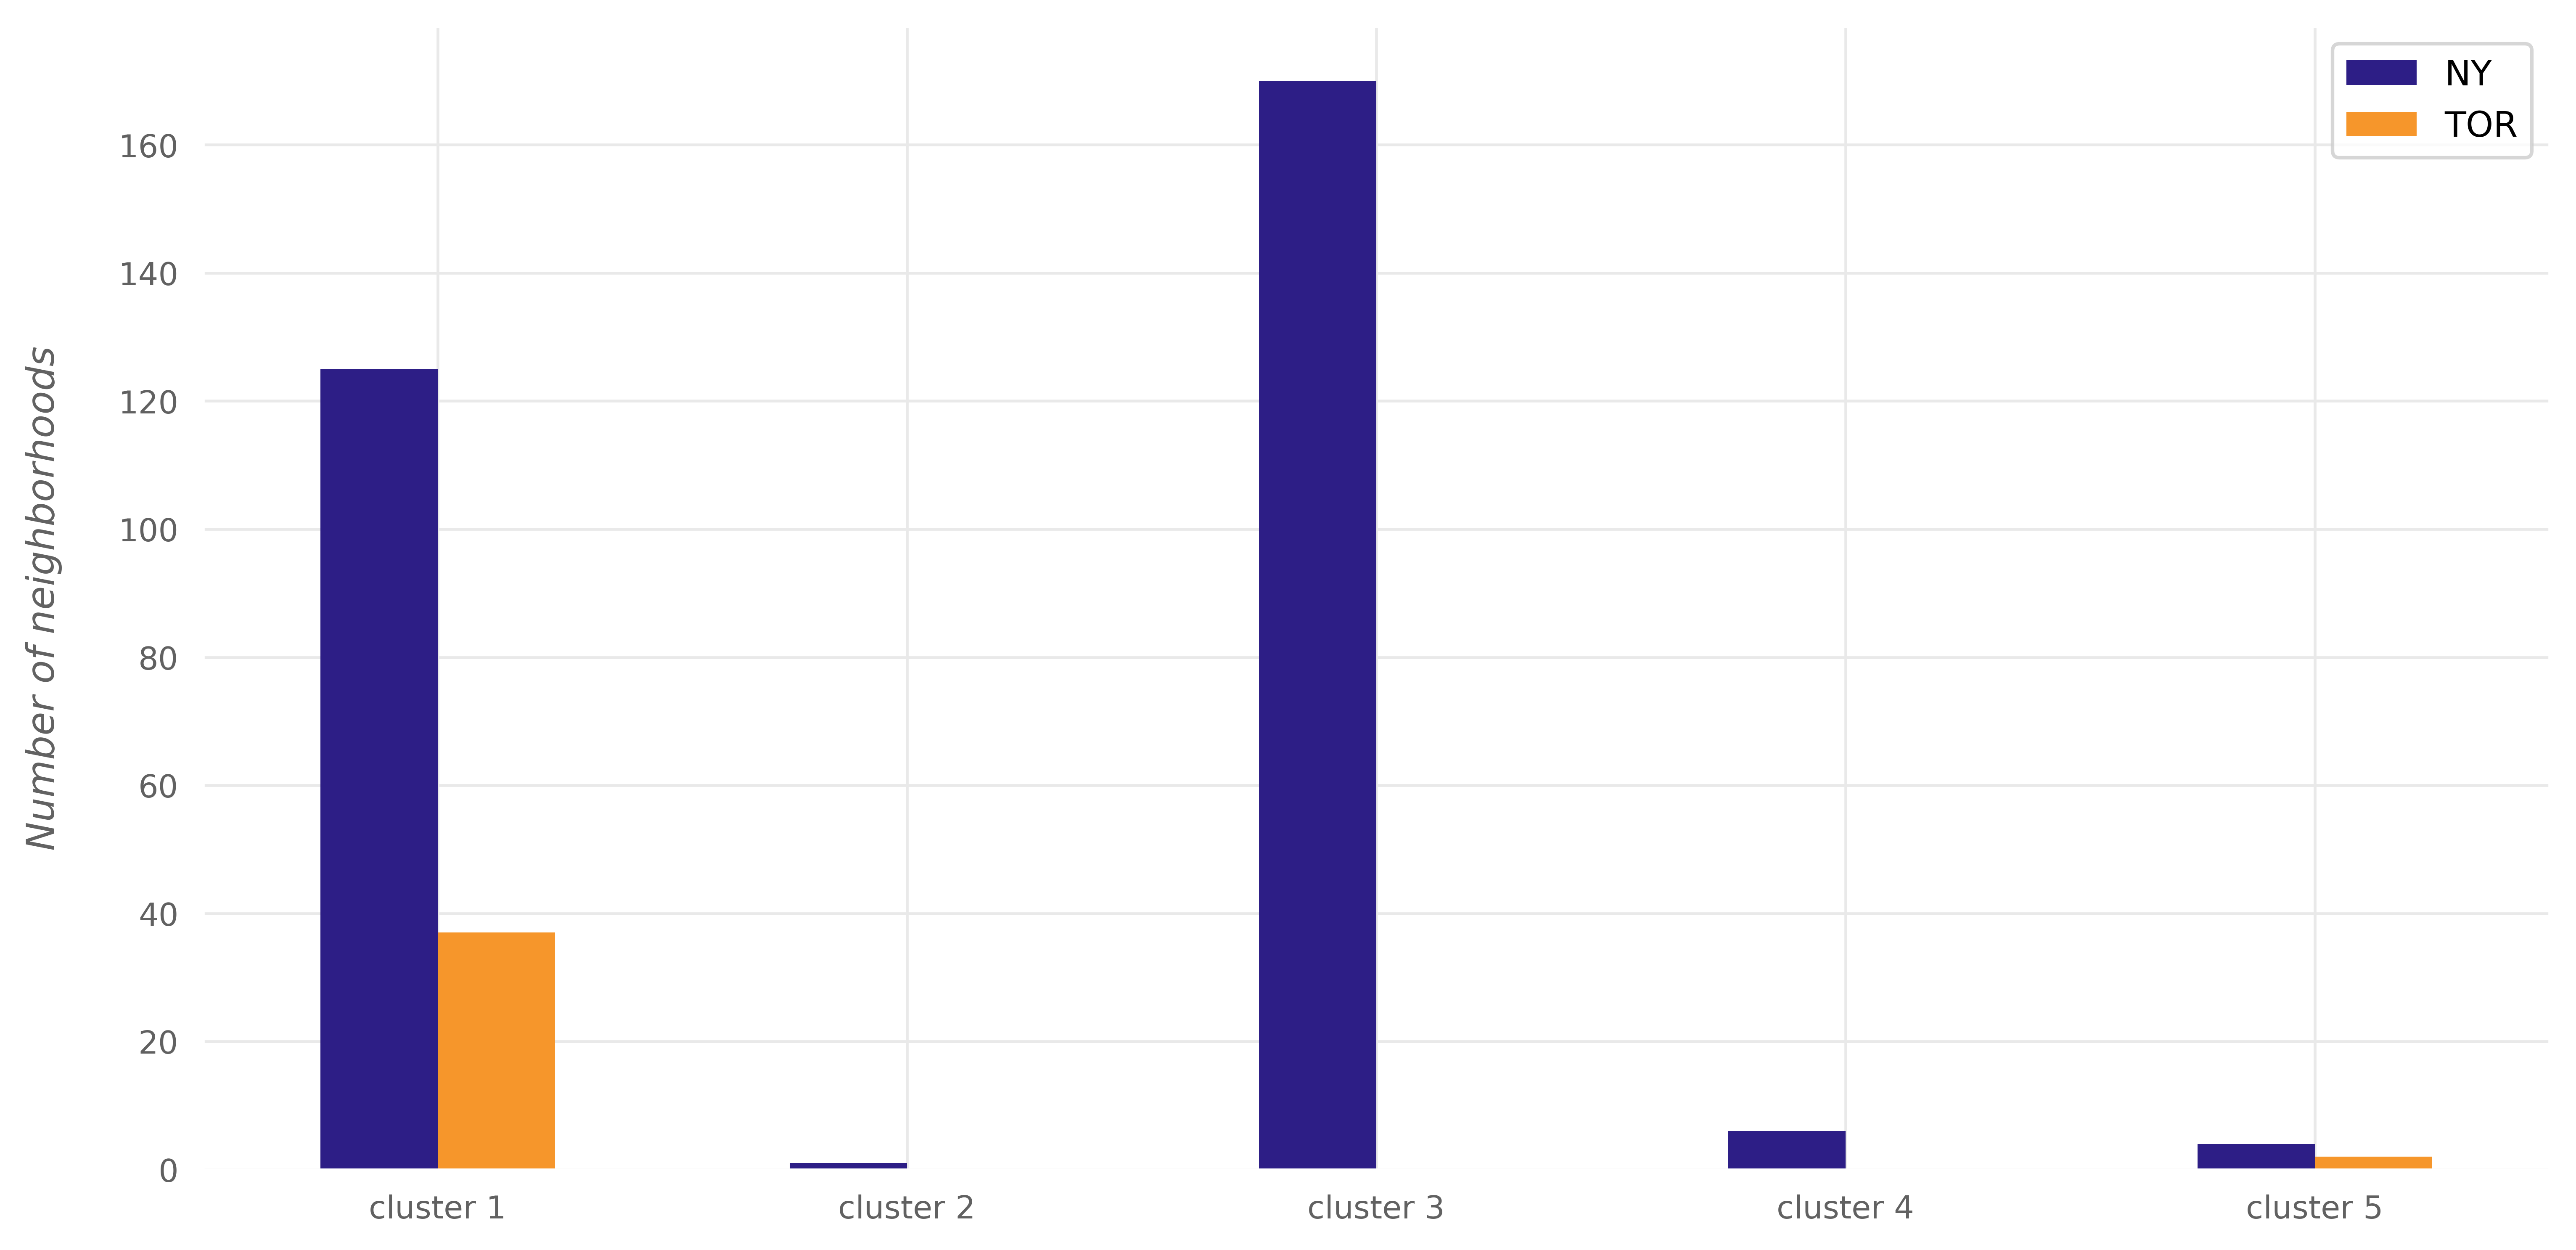

In [190]:
ind = ['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5']
city_c_df = pd.DataFrame({
    'NY': [x[0] for x in n_counts],
    'TOR': [x[1] for x in n_counts]
}, index = ind)

fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
city_c_df.plot(kind='bar', color=['#2d1e86', '#f6962b'], rot=0, ax=ax)
plot_conf(ax, xlbl='', ylbl='Number of neighborhoods', t='')
fig.savefig('city-count.png', dpi=300)